# Distribution figure

In [153]:
fig_save_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper2/figures/'
# comment: It might be easier for readers if the two bars for figures, and the two bars for tables, were adjacent, to allow easier comparison between GROBID and pdffigures2

In [154]:
# where are annotations found?
annotation_files = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/'
# what about pdffigures2?
pdffigures2_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_pdffigures2/' 

# what about grobid results?
grobid_outputs_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCR_caption_extraction/grobid_outputs/'

In [155]:
import os
import glob
import re
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
#import imgaug as ia
#from imgaug import augmenters as iaa
import matplotlib
import pandas as pd
from lxml import etree
from bs4 import BeautifulSoup
import json

In [156]:
# cite: https://www.geeksforgeeks.org/python-program-for-converting-roman-numerals-to-decimal-lying-between-1-to-3999/
def value(r):
    if (r == 'I'):
        return 1
    if (r == 'V'):
        return 5
    if (r == 'X'):
        return 10
    if (r == 'L'):
        return 50
    if (r == 'C'):
        return 100
    if (r == 'D'):
        return 500
    if (r == 'M'):
        return 1000
    return -1
 
def romanToDecimal(str):
    res = 0
    i = 0
 
    while (i < len(str)):
 
        # Getting value of symbol s[i]
        s1 = value(str[i])
 
        if (i + 1 < len(str)):
 
            # Getting value of symbol s[i + 1]
            s2 = value(str[i + 1])
 
            # Comparing both values
            if (s1 >= s2):
 
                # Value of current symbol is greater
                # or equal to the next symbol
                res = res + s1
                i = i + 1
            else:
 
                # Value of current symbol is greater
                # or equal to the next symbol
                res = res + s2 - s1
                i = i + 2
        else:
            res = res + s1
            i = i + 1
 
    return res

In [157]:
romanToDecimal('A')

-1

In [158]:
# years from full dataset
import pickle
import numpy as np
pickleFile = '/Users/jnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/pickleFiles/ids_locations_workflow1_links_boxes.pickle'
with open(pickleFile, 'rb') as f:
    myClass, myClassIDs, locations, conf,\
                 myClassMulti, myClassIDs, locationsM, \
                 links, linksM, bboxes, bboxesM = pickle.load(f)
    
linksall = links.copy()
linksall.extend(linksM)

arts = []; years_this = []; ul = [] # ul holds the unique article name
for l in linksall:
    a = l.split('/')[-2].split('.')[0]
    y = int(a[:4])
    a = a[4:]
    if l.split('/')[-2] not in ul:
        arts.append(a); years_this.append(y); ul.append(l.split('/')[-2])
    

In [159]:
#locations
#links
#links[0:5]

In [160]:
np.unique(arts)

array(['AJ', 'ApJ', 'ApJS'], dtype='<U4')

In [161]:
np.min(years_this),np.max(years_this)

(1852, 1997)

In [162]:
# Grab labels
annotations = glob.glob(annotation_files + '*')
#annotations
years = []
for a in annotations:
    years.append(int(a.split('/')[-1][:4]))
years_unique = np.unique(years).tolist()

In [163]:
annotations[0]

'/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/1985ApJ___298L__21B_p2.xml'

In [164]:
# articles for these annotations
articles_ann = []
for a in annotations:
    a = a.split('/')[-1].split('_')[0]
    a = a[4:]
    articles_ann.append(a)

In [165]:
articles_ann[:3]

['ApJ', 'AJ', 'ApJ']

In [166]:
labels = []; years_labels = []; 
pdf2_has = np.zeros(len(annotations)); pdf2raw_has = pdf2_has.copy() # store if has pdf results or not
pdf2_years = []
for iX,X in enumerate(annotations):
    tree = ET.parse(X)
    fcount = 0; fccount = 0; anycount = 0 
    anycountpdf = 0; anycountpdfraw = 0
    pdf2_years.append(int( X.split('/')[-1][:4]))
    for elem in tree.iter(): 
        if 'object' in elem.tag or 'part' in elem.tag:                  
            for attr in list(elem):
                if 'name' in attr.tag:
                    labels.append(attr.text)
                    years_labels.append(int(X.split('/')[-1][:4]))
                    if attr.text == 'figure': fcount +=1
                    if attr.text == 'figure caption': fccount +=1
                    anycount += 1
        if ('PDFinfo' in elem.tag) and ('RAW' not in elem.tag):                  
            for attr in list(elem):
                if 'name' in attr.tag:
                    anycountpdf += 1
        if 'PDFinfoRAW' in elem.tag in elem.tag:                  
            for attr in list(elem):
                if 'name' in attr.tag:
                    anycountpdfraw += 1
    if anycount == 0: # no labels found anywhere (could be other things like formulas, unconsidered)
        labels.append('no label')
        years_labels.append(int(X.split('/')[-1][:4]))
    if anycountpdf != 0: # has something
        pdf2_has[iX] += 1
    if anycountpdfraw != 0: # no labels found anywhere (could be other things like formulas, unconsidered)
        pdf2raw_has[iX] += 1
    if fccount > fcount:
        print('more cap than fig', X)
LABELS = np.unique(labels)
LABELS

more cap than fig /Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/1985ApJ___298L__21B_p2.xml
more cap than fig /Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/1988ApJS___66__361H_p8.xml
more cap than fig /Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/1981ApJ___243L__99P_p1.xml


array(['figure', 'figure caption', 'math formula', 'no label', 'table'],
      dtype='<U14')

In [167]:
print('total pages=', len(annotations))
for l in LABELS:
    n = np.where(np.array(labels).astype('str')==str(l))[0]
    print(l,len(n))

total pages= 5515
figure 5013
figure caption 4937
math formula 1041
no label 553
table 677


In [168]:
#l

In [169]:
len(pdf2_has), len(pdf2raw_has), len(pdf2_years)

(5515, 5515, 5515)

In [170]:
len(years_labels),len(labels)

(12221, 12221)

In [171]:
labels_years = np.zeros([len(years_unique),len(LABELS)])
for y,l in zip(years_labels,labels):
    iy = years_unique.index(y)
    il = LABELS.tolist().index(l)
    labels_years[iy,il] += 1

In [172]:
#years_labels

In [173]:
df = pd.DataFrame({'years':years_unique})
df['years_old'] = df['years'].copy()
df['years'] = pd.to_datetime(df['years'],format="%Y")

# add other columns
for il,l in enumerate(LABELS):
    df['total:'+l] = labels_years[:,il]

In [174]:
df.head()

,years,years_old,total:figure,total:figure caption,total:math formula,total:no label,total:table
0,1895-01-01,1895,8.0,7.0,1.0,3.0,1.0
1,1896-01-01,1896,8.0,5.0,0.0,2.0,2.0
2,1897-01-01,1897,10.0,8.0,0.0,1.0,0.0
3,1898-01-01,1898,6.0,3.0,3.0,1.0,0.0
4,1899-01-01,1899,1.0,0.0,0.0,2.0,0.0


In [175]:
# histogram over what time bins?
sampleHist = '10Y' # 5 years

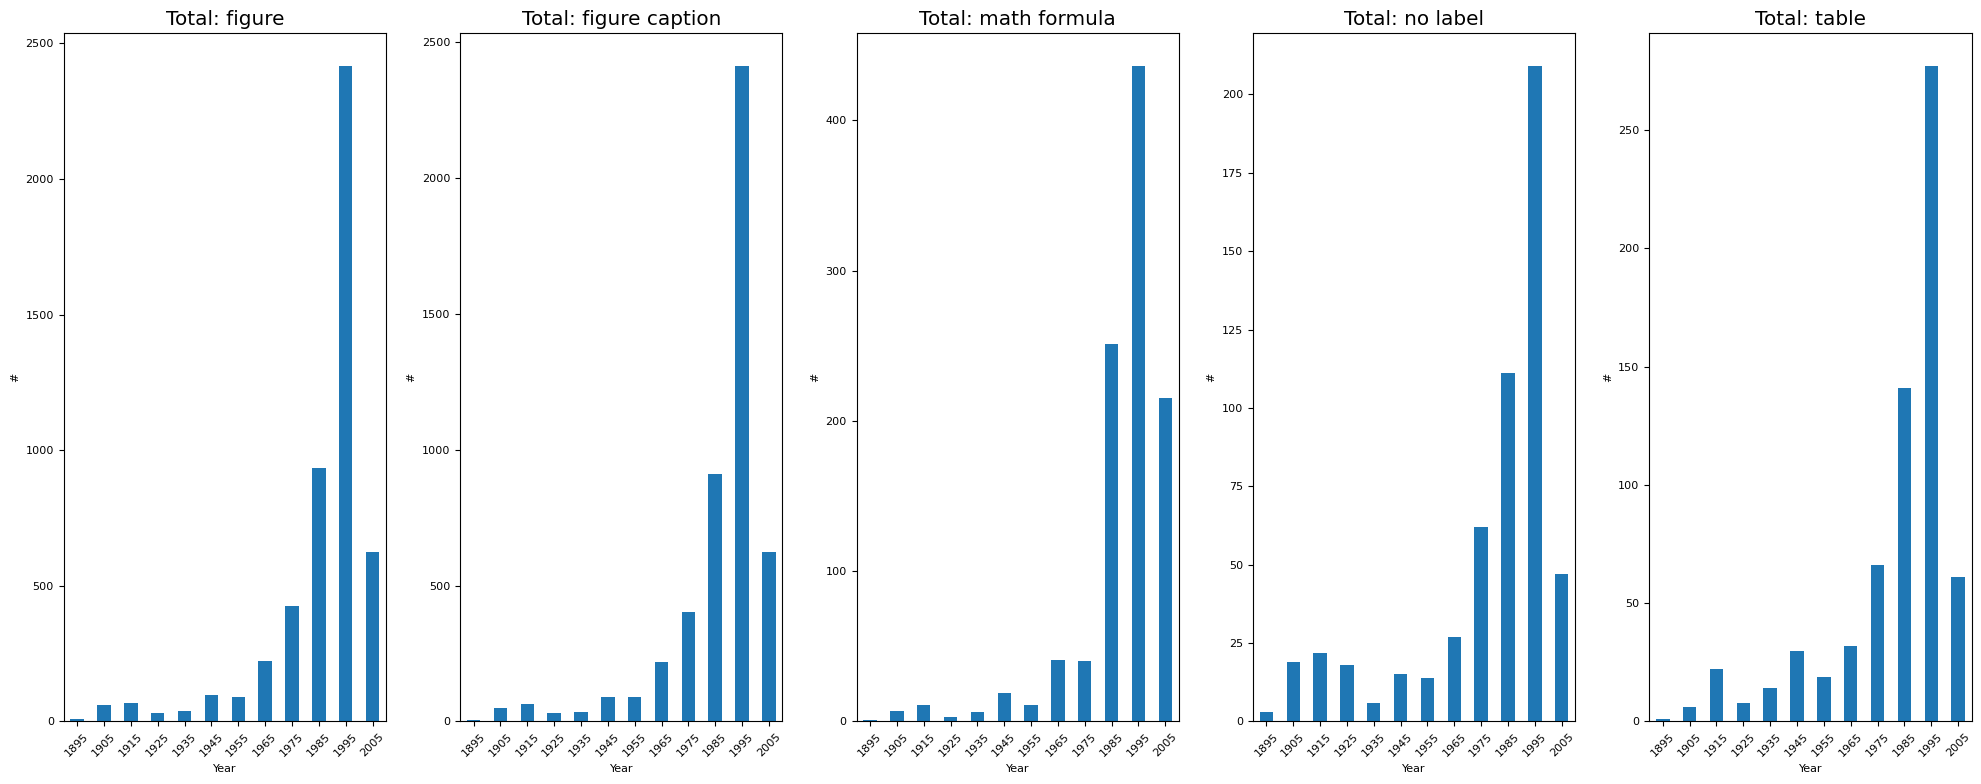

In [176]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

In [177]:
# fig, ax = plt.subplots(1,1, figsize=(8,8))

# quant = pd.DataFrame(index=df['years'],data=np.array(df.drop('years',axis=1)), columns=LABELS).resample(sampleHist).sum()
# #quant.plot(kind='bar',stacked=True, ax=ax)
# quant.plot(kind='bar',stacked=False, ax=ax)

# ax.set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
# ax.set_title('Total: ' + l)
# ax.set_ylabel('#')
# ax.set_xlabel('Year')

# fig.savefig(fig_save_dir + 'year_class_distribution.png')

# plt.show()

In [178]:
# fig,ax = plt.subplots(figsize=(20,8))
# df.plot.bar(x='years', ax=ax)
#quant
#dfallin.columns


In [179]:
from datetime import datetime

In [180]:
dfallin = pd.read_csv("years_journals/Years_all.csv")
# only for refereed
dfall2 = dfallin.loc[dfallin[' Ref Count']>0]

dfall2.head()

,Year,Article Count,Ref Count
162,1665,166,156
163,1666,72,69
165,1668,72,71
166,1669,69,66
167,1670,73,72


In [181]:
# read in individual journals -- ApJ
dfallin = pd.read_csv("years_journals/Years_apj.csv")
# only for refereed
dfsingle = dfallin.loc[dfallin['Year']>=dfall2['Year'].min()]
rsingle = []
for iy in range(len(dfall2)):
    d = dfsingle.loc[dfsingle['Year']==dfall2['Year'].values[iy]]
    if len(d)>0:
        rsingle.append(np.sum(d[' Ref Count'].values))
    else:
        rsingle.append(0)
dfall2['Ref_ApJ'] = np.array(rsingle) # add in this column

In [182]:
dfallin = pd.read_csv("years_journals/Years_aj.csv")
# only for refereed
dfsingle = dfallin.loc[dfallin['Year']>=dfall2['Year'].min()]
rsingle = []
for iy in range(len(dfall2)):
    d = dfsingle.loc[dfsingle['Year']==dfall2['Year'].values[iy]]
    if len(d)>0:
        rsingle.append(np.sum(d[' Ref Count'].values))
    else:
        rsingle.append(0)
dfall2['Ref_AJ'] = np.array(rsingle) # add in this column

In [183]:
dfallin = pd.read_csv("years_journals/Years_apjs.csv")
# only for refereed
dfsingle = dfallin.loc[dfallin['Year']>=dfall2['Year'].min()]
rsingle = []
for iy in range(len(dfall2)):
    d = dfsingle.loc[dfsingle['Year']==dfall2['Year'].values[iy]]
    if len(d)>0:
        rsingle.append(np.sum(d[' Ref Count'].values))
    else:
        rsingle.append(0)
dfall2['Ref_ApJS'] = np.array(rsingle) # add in this column

In [184]:
#finally, include what this work coveres(?)
rsingle = []
years_this = np.array(years_this)
for iy in range(len(dfall2)):
    rsingle.append(len(years_this[years_this==dfall2['Year'].values[iy]]))
dfall2['Years_this'] = np.array(rsingle) # add in this column

In [185]:
dfall2.head()

,Year,Article Count,Ref Count,Ref_ApJ,Ref_AJ,Ref_ApJS,Years_this
162,1665,166,156,0,0,0,0
163,1666,72,69,0,0,0,0
165,1668,72,71,0,0,0,0
166,1669,69,66,0,0,0,0
167,1670,73,72,0,0,0,0


In [186]:
len(dfall2)

288

In [187]:
# so pandas datetime doesn't allow for things older than 1677 because they are dumb, so we'll have to resample on our own
sampleHistLarge = '20Y'
step = int(sampleHistLarge.split('Y')[0])
years = np.arange(dfall2['Year'].min(), dfall2['Year'].max(), step).tolist(); refcount = np.zeros(len(years))
rcount_apj = refcount.copy(); rcount_aj = refcount.copy(); rcount_apjs = refcount.copy(); rcthis = refcount.copy()
if 1997 not in years: years.append(1997)
years = np.array(years)
yearsOut = []
for iy,y in enumerate(years[:-1]):
    inds = np.where((dfall2['Year'].values<=years[iy+1])&(dfall2['Year'].values>years[iy]))[0]
    if len(inds)> 0:
        refcount[iy] = np.sum(dfall2[' Ref Count'].values[inds])
        rcount_apj[iy] = np.sum(dfall2['Ref_ApJ'].values[inds])
        rcount_aj[iy] = np.sum(dfall2['Ref_AJ'].values[inds])
        rcount_apjs[iy] = np.sum(dfall2['Ref_ApJS'].values[inds])
        rcthis[iy]=np.sum(dfall2['Years_this'].values[inds])
    yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
# dfall = pd.DataFrame({'years':yearsOut, 'All ADS Listings of pre-digital articles':refcount, 
#                       'All ApJ':rcount_apj, 'All AJ':rcount_aj, 'All ApJS':rcount_apjs})
# dfall3 = pd.DataFrame({'years':yearsOut, 'All ADS Listings of pre-digital articles':refcount, 'This work':rcthis})
dfall = pd.DataFrame({'years':yearsOut, 'All ADS pre-digital articles':refcount, 
                      'All ApJ':rcount_apj, 'All AJ':rcount_aj, 'All ApJS':rcount_apjs})
dfall3 = pd.DataFrame({'years':yearsOut, 'All ADS pre-digital articles':refcount, 'This work':rcthis})
dfall =dfall.set_index('years'); dfall3 = dfall3.set_index('years')

In [188]:
dfall.head()

,All ADS pre-digital articles,All ApJ,All AJ,All ApJS
years,,,,
1665-01-01 00:00:00,980.0,0.0,0.0,0.0
1685-01-01 00:00:00,870.0,0.0,0.0,0.0
1705-01-01 00:00:00,635.0,0.0,0.0,0.0
1725-01-01 00:00:00,880.0,0.0,0.0,0.0
1745-01-01 00:00:00,1166.0,0.0,0.0,0.0


In [189]:
#arts

In [190]:
# also, from this work alone
years = np.arange(years_this.min(), years_this.max(),1)
rsingle = []; apj = np.zeros(len(years)); aj = apj.copy(); apjs = apj.copy()
for iy in range(len(years)):
    rsingle.append(len(years_this[years_this==years[iy]]))
    inds = np.where(years_this == years[iy])[0]
    if len(inds) > 0:
        u,c = np.unique(np.array(arts)[inds],return_counts=True)
        d = dict(zip(u,c))
        if 'ApJ' in d: apj[iy] = (d['ApJ'])
        if 'ApJS' in d: apjs[iy] = (d['ApJS'])
        if 'AJ' in d: aj[iy] = (d['AJ'])

dfallt = pd.DataFrame({'Year':years, 'Years_this':rsingle, 'Ref_ApJ':apj, 'Ref_AJ':aj, 'Ref_ApJS':apjs})

In [191]:
len(dfallt)

145

In [192]:
dfallt.head()

,Year,Years_this,Ref_ApJ,Ref_AJ,Ref_ApJS
0,1852,1,0.0,1.0,0.0
1,1853,0,0.0,0.0,0.0
2,1854,2,0.0,2.0,0.0
3,1855,0,0.0,0.0,0.0
4,1856,0,0.0,0.0,0.0


In [193]:
# so pandas datetime doesn't allow for things older than 1677 because they are dumb, so we'll have to resample on our own
step = int(sampleHist.split('Y')[0])
#step = int(sampleHistLarge.split('Y')[0])
years = np.arange(dfallt['Year'].min(), dfallt['Year'].max(), step).tolist(); refcount = np.zeros(len(years))
rcount_apj = refcount.copy(); rcount_aj = refcount.copy(); rcount_apjs = refcount.copy(); rcthis = refcount.copy()
if 1997 not in years: years.append(1997)
years = np.array(years)
yearsOut = []
for iy,y in enumerate(years[:-1]):
    inds = np.where((dfallt['Year'].values<=years[iy+1])&(dfallt['Year'].values>years[iy]))[0]
    if len(inds)> 0:
        rcount_apj[iy] = np.sum(dfallt['Ref_ApJ'].values[inds])
        rcount_aj[iy] = np.sum(dfallt['Ref_AJ'].values[inds])
        rcount_apjs[iy] = np.sum(dfallt['Ref_ApJS'].values[inds])
        rcthis[iy]=np.sum(dfallt['Years_this'].values[inds])
    yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
dfallt2 = pd.DataFrame({'years':yearsOut, 'This work total':rcthis, 
                      'ApJ':rcount_apj, 'AJ':rcount_aj, 'ApJS':rcount_apjs})
dfallt3 = pd.DataFrame({'years':yearsOut,  
                      'ApJ':rcount_apj, 'AJ':rcount_aj, 'ApJS':rcount_apjs})
dfallt2 =dfallt2.set_index('years'); dfallt3 =dfallt3.set_index('years')

In [194]:
dfallt2.head()

,This work total,ApJ,AJ,ApJS
years,,,,
1852-01-01,2.0,0.0,2.0,0.0
1862-01-01,0.0,0.0,0.0,0.0
1872-01-01,0.0,0.0,0.0,0.0
1882-01-01,1.0,0.0,1.0,0.0
1892-01-01,167.0,166.0,1.0,0.0


In [195]:
step = int(sampleHist.split('Y')[0])
#step = int(sampleHistLarge.split('Y')[0])
years = np.arange(dfallt['Year'].min(), dfallt['Year'].max(), step).tolist(); refcount = np.zeros(len(years))
rcount_fig = np.zeros(len(years)); rcount_cap = rcount_fig.copy(); 
rcount_tab = rcount_fig.copy(); rcount_math=rcount_fig.copy()
rcount_no = rcount_fig.copy()
if 1997 not in years: years.append(1997)
years = np.array(years)
yearsOut = []
years_save = years.copy()
for iy,y in enumerate(years[:-1]):
    inds = np.where((df['years_old'].values<=years[iy+1])&(df['years_old'].values>years[iy]))[0]
    if len(inds)> 0:
        rcount_fig[iy] = np.sum(df['total:figure'].values[inds])
        rcount_cap[iy] = np.sum(df['total:figure caption'].values[inds])
        rcount_tab[iy] = np.sum(df['total:table'].values[inds])
        rcount_math[iy] = np.sum(df['total:math formula'].values[inds])
        rcount_no[iy] = np.sum(df['total:no label'].values[inds])
    yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
#df2 = pd.DataFrame({'years':yearsOut, 'figure':rcount_fig, 'figure caption':rcount_cap, 'table':rcount_tab,
#                    'math formula':rcount_math, 'no label':rcount_no})
df2 = pd.DataFrame({'years':yearsOut, 'figure':rcount_fig, 'figure caption':rcount_cap, 'table':rcount_tab,
                    'math formula':rcount_math})
df2 =df2.set_index('years')

#quant = pd.DataFrame(index=df['years'],data=np.array(df.drop('years',axis=1)), columns=LABELS).resample(sampleHist).sum()


## PDF parsing info

(Using grobid & pdffigures2 results)

In [196]:
dfpdf2 = pd.DataFrame({'years':pdf2_years, 'has_pdf':pdf2_has, 'has_raw':pdf2raw_has, 'article':articles_ann})
dfpdf2['years'] = pd.to_datetime(dfpdf2['years'],format="%Y")

In [197]:
dfpdf2.head()

,years,has_pdf,has_raw,article
0,1985-01-01,0.0,0.0,ApJ
1,1987-01-01,1.0,0.0,AJ
2,1913-01-01,0.0,0.0,ApJ
3,1990-01-01,0.0,0.0,ApJ
4,1912-01-01,0.0,0.0,ApJ


In [198]:
#xx=pd.Series(index=dfpdf2['years'],data=np.array(dfpdf2[qname]))
#xx.resample?

In [199]:
#pd.Series(index=dfpdf2['years'],data=np.array(dfpdf2[qname])).resample
len(dfpdf2)

5515

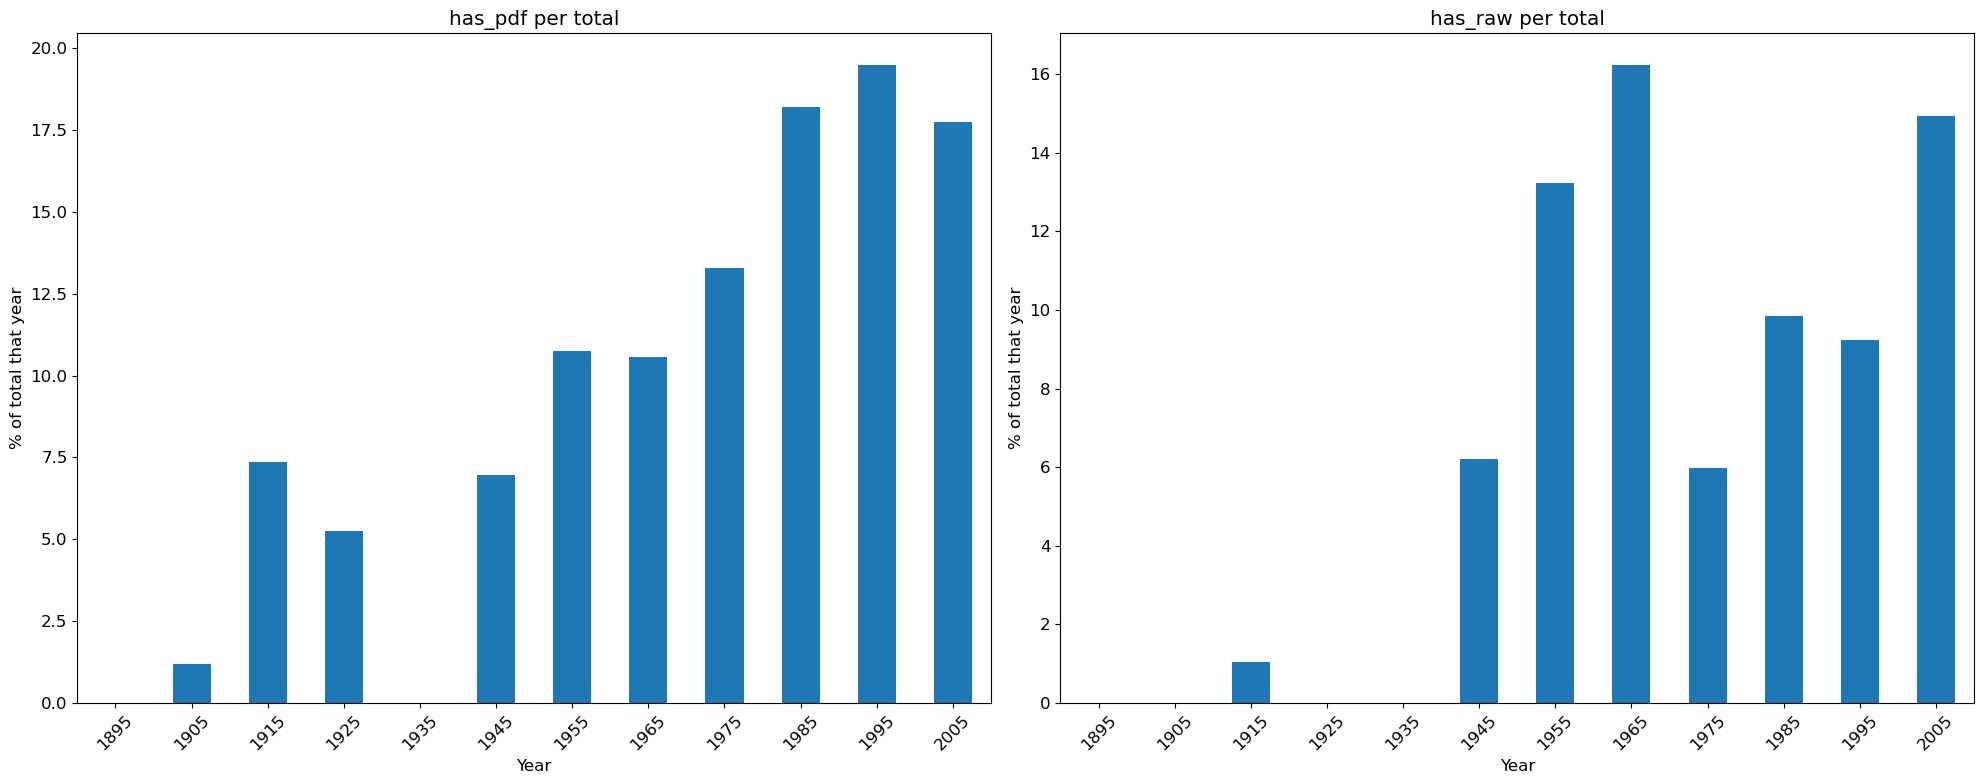

In [200]:
qnames = ['has_pdf','has_raw']
sampleHist = '10Y'

fig, ax = plt.subplots(1,len(qnames), figsize=(20,8))

for il,qname in enumerate(qnames):
    counts = pd.Series(index=dfpdf2['years'],data=np.array(dfpdf2[qname])).resample(sampleHist,label='left').sum()
    tot = dfpdf2['years'].value_counts().resample(sampleHist).sum() 
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qname+' per total')
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Per journal:

In [201]:
np.unique(dfpdf2['article']).tolist(), quant

(['AJ', 'ApJ', 'ApJS'],
 1895-12-31     0.000000
 1905-12-31     0.000000
 1915-12-31     1.052632
 1925-12-31     0.000000
 1935-12-31     0.000000
 1945-12-31     6.201550
 1955-12-31    13.223140
 1965-12-31    16.226415
 1975-12-31     5.973025
 1985-12-31     9.834559
 1995-12-31     9.236948
 2005-12-31    14.925373
 Freq: 10A-DEC, dtype: float64)

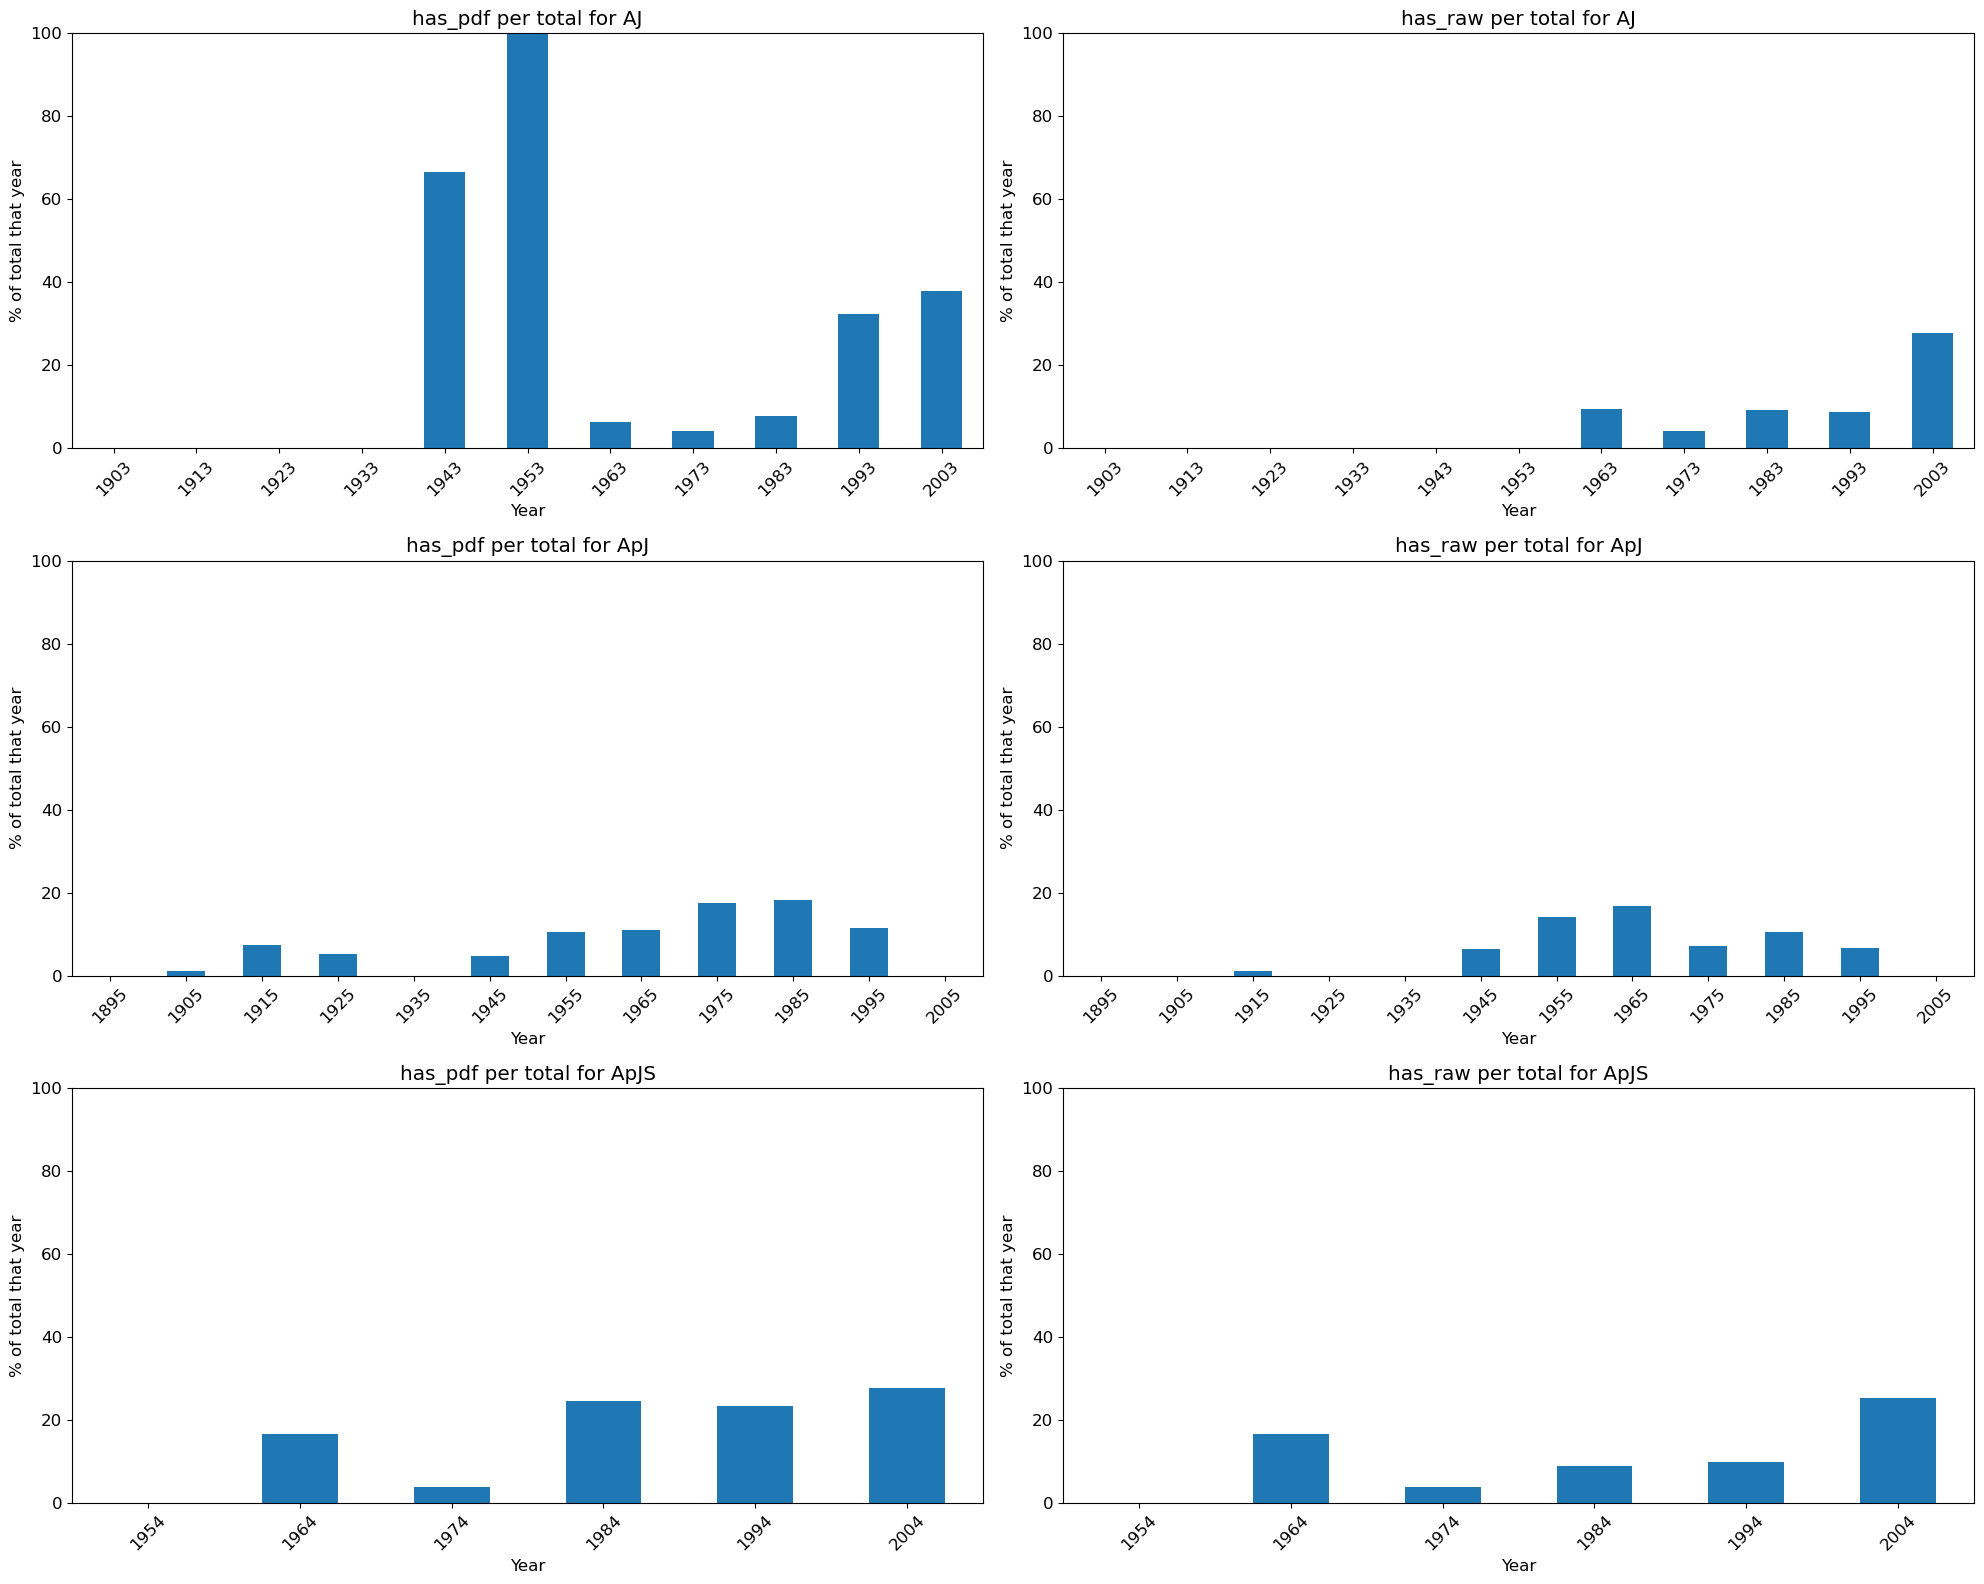

In [202]:
qnames = ['has_pdf','has_raw']
sampleHist = '10Y'

fig, ax = plt.subplots(len(np.unique(dfpdf2['article'])),len(qnames), figsize=(20,8*2))

for il,qname in enumerate(qnames):
    #dfhere = pd.DataFrame({})
    for iar,ar in enumerate(np.unique(dfpdf2['article']).tolist()):
        index = dfpdf2.loc[dfpdf2['article']==ar]['years']
        #index = dfpdf2['years']
        data = np.array(dfpdf2.loc[dfpdf2['article']==ar][qname])
        counts = pd.Series(index=index,data=data).resample(sampleHist,label='left').sum()
        tot = dfpdf2.loc[dfpdf2['article']==ar]['years'].value_counts().resample(sampleHist).sum() 
        with np.errstate(invalid='ignore'): # take care of zeros later
            quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
        quant.plot(kind='bar',ax=ax[iar][il])
        #dfhere[ar] = quant.values
    #dfhere['years'] = quant.index.values
    #dfhere = dfhere.set_index('years')   
    #dfhere.plot(kind='bar',ax=ax[il], stacked=False)
        
        ax[iar][il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
        ax[iar][il].set_title(qname+' per total for ' + ar)
        ax[iar][il].set_ylabel('% of total that year')
        ax[iar][il].set_xlabel('Year')
        ax[iar][il].set_ylim(0,100)
    
plt.tight_layout()
plt.show()


The above is at the page level.  We also want info for FULL articles.  To do this, not only do we want them to have figures and captions on one page, we want full throughout the article, not just raw boxes AND in the correct order.  For this, we need the json files from our pdffigures2 runs.

In [203]:
# find page list
annsm = []
for a in annotations:
    annsm.append(a.split('/')[-1].split('_p')[0])
annsm = np.unique(annsm).tolist()

In [204]:
pdf2list = []
for a in annsm:
    pdf2list.append(pdffigures2_dir + a + '.json') # not all of these will exist
len(pdf2list)

3769

In [205]:
pdf2list[:5]

['/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_pdffigures2/1895ApJ_____1__101K.json',
 '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_pdffigures2/1895ApJ_____1__162H.json',
 '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_pdffigures2/1895ApJ_____1__212F.json',
 '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_pdffigures2/1895ApJ_____1__305P.json',
 '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_pdffigures2/1895ApJ_____1__416K.json']

In [206]:
annsm[:5]

['1895ApJ_____1__101K',
 '1895ApJ_____1__162H',
 '1895ApJ_____1__212F',
 '1895ApJ_____1__305P',
 '1895ApJ_____1__416K']

Try parsing an example:

In [207]:
#pdf2list

# # count things that aren't tracked
# romans = ['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII',
#        'VIII', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XIX', 'XV', 'XVI',
#        'XVIII', 'XX', 'XXII', 'XXIX', 'XXV', 'XXVI', 'XXVII', 'XXVIII',
#        'XXX', 'XXXI', 'XXXII', 'XXXIV', 'XXXIX', 'XXXVI', 'XXXVII']

# find one!
allnames = []; tracked = []
for ip in range(len(pdf2list)):
    p = pdf2list[ip]
    #print('file is', p)
    if os.path.isfile(p):
        with open(p,'r') as f:
            data = json.loads(f.read())
        for fig in data['figures']:
            #print('have figs!')
            allnames.append(fig['name'])
            if fig['name'].isdigit():
                tracked.append(True)
            elif romanToDecimal(fig['name']) > 0:
                tracked.append(True)
            else:
                tracked.append(False)
allnamesu = np.unique(allnames)

In [208]:
allnamesu

array(['1', '1-1', '1-12', '1-14', '1-2', '1-3', '1-4', '1-73', '1.408',
       '10', '100', '101', '102', '103', '105', '106', '108', '109', '11',
       '11,12', '110', '112', '113', '114', '116', '117', '118', '119',
       '12', '120', '121', '123', '124', '125', '126', '127', '129', '13',
       '130', '131', '134', '136', '137', '14', '146', '15', '156', '16',
       '17', '176', '18', '186', '19', '196', '2', '2/2', '2/7', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '286', '29', '3',
       '3(1', '3-6', '3.2', '3.7', '3/1', '30', '31', '32', '33', '34',
       '346', '35', '36', '366', '37', '376', '38', '39', '4', '4-1',
       '4-3', '4-5', '4-7', '40', '41', '42', '43', '44', '446', '45',
       '46', '466', '47', '48', '486', '49', '5', '5-7', '50', '51', '52',
       '53', '54', '55', '56', '57', '58', '59', '5—6', '6', '6/7', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70',
       '71', '72', '73', '74', '76', '77', '78', '79'

In [209]:
dfallnames = pd.DataFrame({'name':allnames,'tracked':tracked})

<AxesSubplot:>

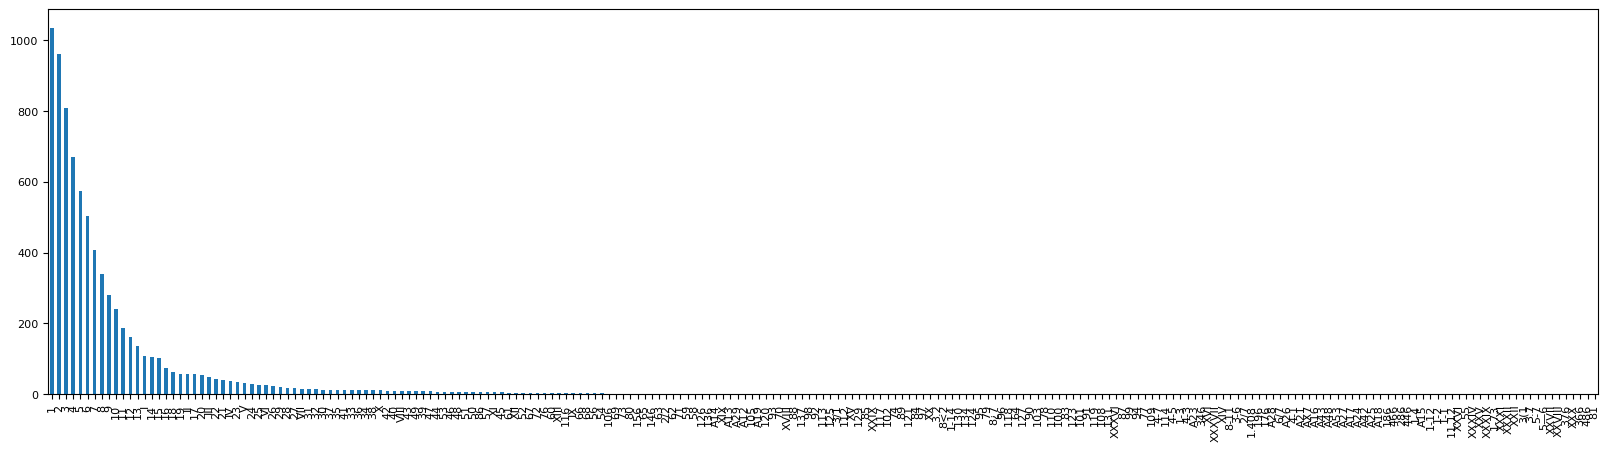

In [210]:
dfallnames['name'].value_counts().plot(kind='bar', figsize=(20,5),fontsize=8)

In [211]:
print('we are not tracking:', round(len(dfallnames.loc[~dfallnames['tracked']])/len(dfallnames)*100,2), '% of all instances of figures')

we are not tracking: 0.66 % of all instances of figures


Parse all of them:

In [212]:
has_figs_p2 = np.zeros(len(pdf2list))
has_tabs_p2 = np.zeros(len(pdf2list))
mono_figs_p2 = np.zeros(len(pdf2list)); mono_tabs_p2 = np.zeros(len(pdf2list))
mono2_figs_p2 = mono_figs_p2.copy(); mono2_tabs_p2 = mono_tabs_p2.copy() # count another way
no_repeat_figs = mono_figs_p2.copy(); no_repeat_tabs = mono_figs_p2.copy() # count repeat nums
# also, count just roman numberals and just numbers
mono2_figs_p2_num = mono2_figs_p2.copy()
mono2_figs_p2_either = mono2_figs_p2.copy()
mono2_figs_p2_roman = mono2_figs_p2.copy()
mono2_tabs_p2_num = mono2_figs_p2.copy()
mono2_tabs_p2_roman = mono2_figs_p2.copy()
mono2_tabs_p2_either = mono2_figs_p2.copy()
no_repeat_figs_num = mono_figs_p2.copy(); 
no_repeat_figs_roman = mono_figs_p2.copy(); 
no_repeat_tabs_num = mono_figs_p2.copy() 
no_repeat_tabs_roman = mono_figs_p2.copy() 

found_figs = []
found_tables = []

art_save_pdf= []
years = []
names = []
# romans = ['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII',
#        'VIII', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XIX', 'XV', 'XVI',
#        'XVIII', 'XX', 'XXII', 'XXIX', 'XXV', 'XXVI', 'XXVII', 'XXVIII',
#        'XXX', 'XXXI', 'XXXII', 'XXXIV', 'XXXIX', 'XXXVI', 'XXXVII']
# nums = [1,2,3,4, 9, 5, 6, 7, 8, 10, 11, 12, 13, 14, 19, 15, 16, 18, 20, 22, 29, 25, 26, 27, 28, 
#         30, 31, 32, 34, 39, 36, 37]
for ip,p in enumerate(pdf2list):
    figs_found_here = []; tabs_found_here = []
    art_save_pdf.append(p.split('/')[-1].split('_')[0][4:])
    if ip%500 == 0: print('on', ip, 'of', len(pdf2list)-1)
    years.append(int(p.split('/')[-1][:4]))
    if os.path.isfile(p):
        with open(p,'r') as f:
            data = json.loads(f.read())
            fnames = []; ftype = []
            fnames_num = []; ftype_num = []
            fnames_roman = []; ftype_roman = []
        for fig in data['figures']:
            name = fig['name']; name_num = -1; name_roman = -1
            if not name.isdigit(): # try roman numerals
                if romanToDecimal(name) > 0:
                    name = str(romanToDecimal(name))
                    name_roman = str(romanToDecimal(name))
            if not name.isdigit() and name[1:].isdigit():
                name = name[1:]
                name_num = name[1:]
            names.append(name)
            # digit or no?
            if name.isdigit():
                fnames.append(int(name))
                if name_num != -1: # if a number
                    fnames_num.append(int(name))
                    ftype_num.append(fig['figType'].lower())
                elif name_roman != -1: # from roman
                    fnames_roman.append(int(name))
                    ftype_roman.append(fig['figType'].lower())
            else:
                fnames.append(-1)
            ftype.append(fig['figType'].lower())
            if fig['figType'].lower()
                figs_found_here.append(name)

        if 'figure' in fnames:
            has_figs_p2[ip] += 1
        if 'table' in fnames:
            has_tabs_p2[ip] += 1
        # do some checks
        fig_nums = []; table_nums = []
        fig_nums_num = []; table_nums_num = []
        fig_nums_roman = []; table_nums_roman = []
        # all
        for f,n in zip(ftype,fnames):
            if f == 'figure':
                fig_nums.append(n)
            elif f == 'table':
                table_nums.append(n)
            else:
                print('somthing odd has happened')
                import sys; sys.exit()
        # now just nums
        for f,n in zip(ftype_num,fnames_num):
            if f == 'figure':
                fig_nums_num.append(n)
            elif f == 'table':
                table_nums_num.append(n)
            else:
                print('somthing odd has happened')
                import sys; sys.exit()
        # now just romans
        for f,n in zip(ftype_roman,fnames_roman):
            if f == 'figure':
                fig_nums_roman.append(n)
            elif f == 'table':
                table_nums_roman.append(n)
            else:
                print('somthing odd has happened')
                import sys; sys.exit()
            
            
        if len(fig_nums) > 0:
            # first, check if monotonically increasing across all types of counting (numbers + romans)
            fig_mono = np.all(np.array(fig_nums)[1:] == np.array(fig_nums)[:-1]+1) and fig_nums[0]==1 # all are monotioncially increasing?
            if fig_mono: mono_figs_p2[ip] += 1
            # do the same check, but after sorting
            fig_mono2 = np.all(np.sort(fig_nums)[1:] == np.sort(fig_nums)[:-1]+1) and fig_nums[0]==1
            if fig_mono2: mono2_figs_p2[ip] += 1
            # check for repeats
            if len(np.unique(fig_nums)) == len(fig_nums): no_repeat_figs[ip] += 1
            
            # now, check seperately for romans and numbers (do sorted by default)
            # nums
            fig_mono2_num = False; fig_mono2_roman = False
            if len(fig_nums_num)>0:
                fig_mono2_num = np.all(np.sort(fig_nums_num)[1:] == np.sort(fig_nums_num)[:-1]+1) and fig_nums_num[0]==1
                if fig_mono2_num: mono2_figs_p2_num[ip] += 1
                # check for repeats
                if len(np.unique(fig_nums_num)) == len(fig_nums_num): no_repeat_figs_num[ip] += 1
            # romans
            if len(fig_nums_roman)>0:
                fig_mono2_roman = np.all(np.sort(fig_nums_roman)[1:] == np.sort(fig_nums_roman)[:-1]+1) and fig_nums_roman[0]==1
                if fig_mono2_roman: mono2_figs_p2_roman[ip] += 1
                # check for repeats
                if len(np.unique(fig_nums_roman)) == len(fig_nums_roman): no_repeat_figs_roman[ip] += 1  
            if fig_mono2_num or fig_mono2_roman:
                mono2_figs_p2_either[ip] += 1
            
        if len(table_nums) > 0: # same thing for tables
            tab_mono = np.all(np.array(table_nums)[1:] == np.array(table_nums)[:-1]+1) and table_nums[0]==1
            if tab_mono: mono_tabs_p2[ip] += 1
            tab_mono2 = np.all(np.sort(table_nums)[1:] == np.sort(table_nums)[:-1]+1) and table_nums[0]==1
            if tab_mono2: mono2_tabs_p2[ip] += 1
            if len(np.unique(table_nums)) == len(table_nums): no_repeat_tabs[ip] += 1
            
            # now, check seperately for romans and numbers (do sorted by default)
            # nums
            tab_mono2_num = False; tab_mono2_roman=False
            if len(table_nums_num)>0:
                tab_mono2_num = np.all(np.sort(table_nums_num)[1:] == np.sort(table_nums_num)[:-1]+1) and table_nums_num[0]==1
                if tab_mono2_num: mono2_tabs_p2_num[ip] += 1
                # check for repeats
                if len(np.unique(table_nums_num)) == len(table_nums_num): no_repeat_tabs_num[ip] += 1
            # romans
            if len(table_nums_roman)>0:
                tab_mono2_roman = np.all(np.sort(table_nums_roman)[1:] == np.sort(table_nums_roman)[:-1]+1) and table_nums_roman[0]==1
                if tab_mono2_roman: mono2_tabs_p2_roman[ip] += 1
                # check for repeats
                if len(np.unique(table_nums_roman)) == len(table_nums_roman): no_repeat_tabs_roman[ip] += 1   
            if tab_mono2_num or tab_mono2_roman:
                mono2_tabs_p2_either[ip] += 1
    if np.sum(np.unique(mono2_figs_p2))>1: import sys; sys.exit()
            
            
df_pdf2 = pd.DataFrame({'Year':years,  
                   'has_figs':has_figs_p2, 'has_tabs':has_tabs_p2, 'mono_figs':mono_figs_p2, 'mono_tabs':mono_tabs_p2,
                        'mono2_figs':mono2_figs_p2, 'mono2_tabs':mono2_tabs_p2, 
                        'no_rep_figs':no_repeat_figs, 'no_rep_tabs':no_repeat_tabs, 
                       'article':art_save_pdf,
                       'mono_figs_num':mono2_figs_p2_num, 'mono_figs_roman':mono2_figs_p2_roman, 
                        'no_repeat_figs_num':no_repeat_figs_num, 'no_repeat_figs_roman':no_repeat_figs_roman,
                        'mono_tabs_num':mono2_tabs_p2_num, 'mono_tabs_roman':mono2_tabs_p2_roman, 
                        'no_repeat_tabs_num':no_repeat_tabs_num, 'no_repeat_tabs_roman':no_repeat_tabs_roman,
                       'mono_figs_either':mono2_figs_p2_either, 'mono_tabs_either':mono2_tabs_p2_either})


print('all done! I made you a nice dataframe :D')

on 0 of 3768
on 500 of 3768
on 1000 of 3768
on 1500 of 3768
on 2000 of 3768
on 2500 of 3768
on 3000 of 3768
on 3500 of 3768
all done! I made you a nice dataframe :D


In [213]:
print('total parsable across ALL articles in figures (all) =',df_pdf2['mono2_figs'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (all) =',df_pdf2['mono2_tabs'].sum()/len(df_pdf2)*100)
print('')
print('total parsable across ALL articles in figures (nums) =',df_pdf2['mono_figs_num'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (nums) =',df_pdf2['mono_tabs_num'].sum()/len(df_pdf2)*100)
print('')
print('total parsable across ALL articles in figures (romans) =',df_pdf2['mono_figs_roman'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (romans) =',df_pdf2['mono_tabs_roman'].sum()/len(df_pdf2)*100)
print('')
print('total parsable across ALL articles in figures (either nums or romans) =',df_pdf2['mono_figs_either'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (either nums or romans) =',df_pdf2['mono_tabs_either'].sum()/len(df_pdf2)*100)

total parsable across ALL articles in figures (all) = 3.0777394534359246
total parsable across ALL articles in tables (all) = 5.863624303528788

total parsable across ALL articles in figures (nums) = 0.0
total parsable across ALL articles in tables (nums) = 0.0

total parsable across ALL articles in figures (romans) = 0.716370390023879
total parsable across ALL articles in tables (romans) = 1.1408861767046963

total parsable across ALL articles in figures (either nums or romans) = 0.716370390023879
total parsable across ALL articles in tables (either nums or romans) = 1.1408861767046963


In [ ]:
# where is there a difference between either/or
for i in range(

In [243]:
ftype

['figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure',
 'figure']

In [214]:
years = years_save.copy()
mono_figs = np.zeros(len(years)-1); mono_tabs = mono_figs.copy()
mono_figs_apj = mono_figs.copy(); mono_figs_aj = mono_figs.copy(); mono_figs_apjs = mono_figs.copy()
mono_tabs_apj = mono_figs.copy(); mono_tabs_aj = mono_figs.copy(); mono_tabs_apjs = mono_figs.copy()
totals = mono_figs.copy()
journals = ['ApJ', 'AJ', 'ApJS']
mono_figs_j = [mono_figs_apj, mono_figs_aj, mono_figs_apjs]
mono_tabs_j = [mono_tabs_apj, mono_tabs_aj, mono_tabs_apjs]

yearsOut = []
for iy,y in enumerate(years[:-1]):
    inds = np.where((df_pdf2['Year'].values<=years[iy+1])&(df_pdf2['Year'].values>years[iy]))[0]
    if len(inds)> 0:
        # all:
        # totals[iy]=len(inds)
        # mono_figs[iy] = np.sum(df_pdf2['mono2_figs'].values[inds])/totals[iy]*100
        # mono_tabs[iy] = np.sum(df_pdf2['mono2_tabs'].values[inds])/totals[iy]*100
        #mono_figs[iy] = np.sum(df_pdf2['mono2_figs'].values[inds])/len(df_pdf2)*100 
        mono_figs[iy] = np.sum(df_pdf2['mono_figs_either'].values[inds])/len(df_pdf2)*100 
        if mono_figs[iy]>3: import sys; sys.exit()
        #mono_tabs[iy] = np.sum(df_pdf2['mono2_tabs'].values[inds])/len(df_pdf2)*100    
        mono_tabs[iy] = np.sum(df_pdf2['mono_tabs_either'].values[inds])/len(df_pdf2)*100    
    yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
    for j,mj,tj in zip(journals,mono_figs_j,mono_tabs_j):
        dfpdfh = df_pdf2.loc[df_pdf2['article']==j]
        if len(dfpdfh)>0:
            inds = np.where((dfpdfh['Year'].values<=years[iy+1])&(dfpdfh['Year'].values>years[iy]))[0]
            if len(inds)>0:
                tot = len(inds)
                #tot = len(dfpdfh)
                mj[iy] = np.sum(dfpdfh['mono2_figs'].values[inds])/tot*100
                tj[iy] = np.sum(dfpdfh['mono2_tabs'].values[inds])/tot*100
            

df_pdf22 = pd.DataFrame({'years':yearsOut,'mono_figs':mono_figs, 'mono_tabs':mono_tabs, 
                        'mono_figs_apj':mono_figs_apj, 'mono_figs_aj':mono_figs_aj, 'mono_figs_apjs':mono_figs_apjs,
                        'mono_tabs_apj':mono_tabs_apj, 'mono_tabs_aj':mono_tabs_aj, 'mono_tabs_apjs':mono_tabs_apjs})#, 'total articles':totals})
df_pdf22 = df_pdf22.set_index('years')

In [215]:
df_pdf22.head()

,mono_figs,mono_tabs,mono_figs_apj,mono_figs_aj,mono_figs_apjs,mono_tabs_apj,mono_tabs_aj,mono_tabs_apjs
years,,,,,,,,
1852-01-01,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1862-01-01,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1872-01-01,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1882-01-01,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1892-01-01,0.053064,0.079597,1.851852,0.0,0.0,5.555556,0.0,0.0


In [216]:
df_pdf2.head()

,Year,has_figs,has_tabs,mono_figs,mono_tabs,mono2_figs,mono2_tabs,no_rep_figs,no_rep_tabs,article,mono_figs_num,mono_figs_roman,no_repeat_figs_num,no_repeat_figs_roman,mono_tabs_num,mono_tabs_roman,no_repeat_tabs_num,no_repeat_tabs_roman,mono_figs_either,mono_tabs_either
0,1895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ApJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ApJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ApJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ApJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ApJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
# print('total parsable across ALL articles in figures =',df_pdf2['mono2_figs'].sum()/len(df_pdf2)*100)
# print('total parsable across ALL articles in tables =',df_pdf2['mono2_tabs'].sum()/len(df_pdf2)*100)

In [218]:
df_pdf2['mono2_figs'].unique(), np.sum(np.unique(df_pdf2['mono2_figs']))

(array([0., 1.]), 1.0)

In [219]:
#df_pdf22['mono_figs']

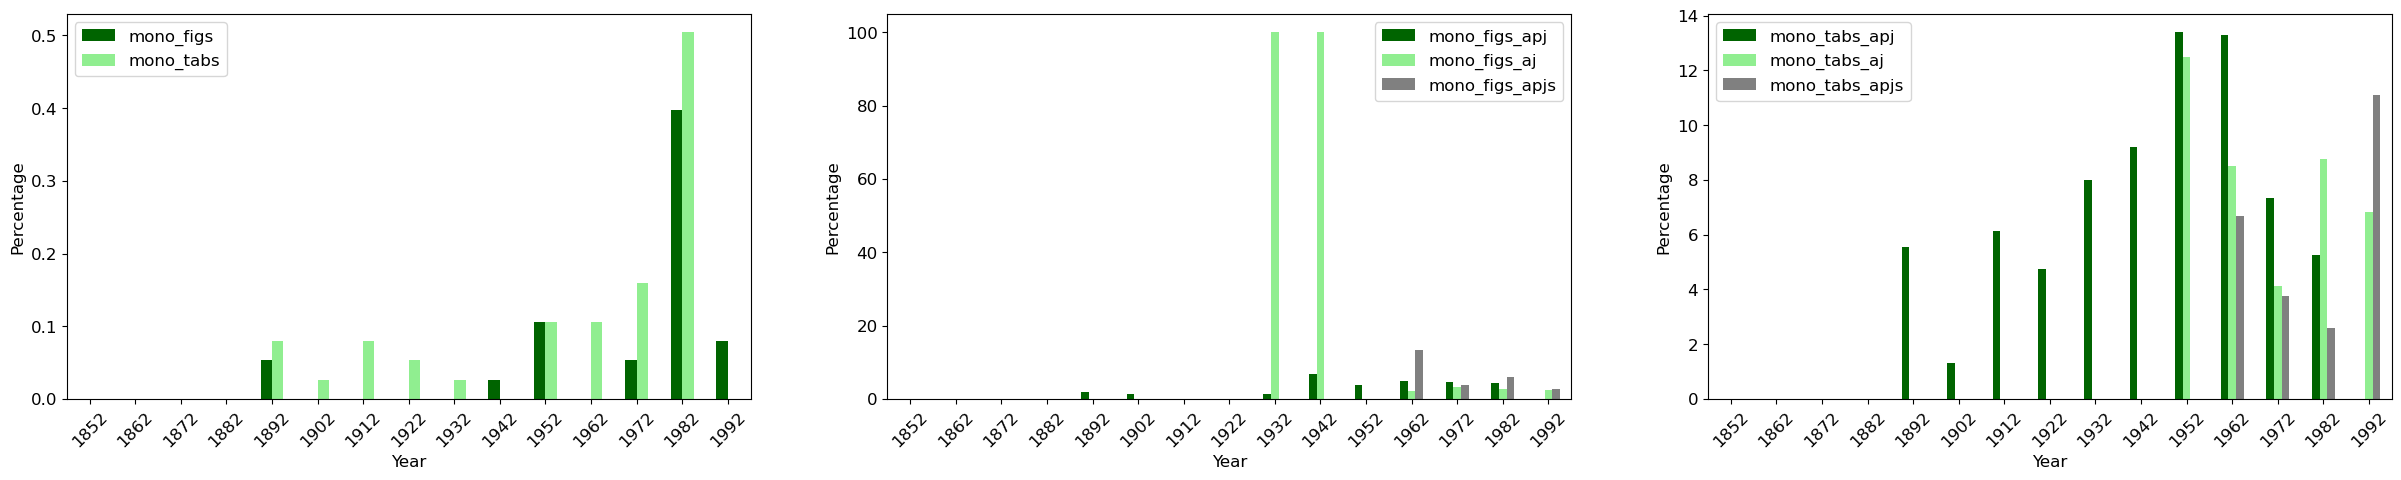

In [220]:

fig, ax = plt.subplots(1,3,figsize=(30,5))
df_pdf22.plot(kind='bar',y=['mono_figs','mono_tabs'],stacked=False, ax=ax[0], color=['darkgreen','lightgreen','gray'])
ax[0].set_xticklabels([x.strftime("%Y") for x in df_pdf22.index], rotation=45)

df_pdf22.plot(kind='bar',y=['mono_figs_apj','mono_figs_aj','mono_figs_apjs'],stacked=False, ax=ax[1], color=['darkgreen','lightgreen','gray'])
ax[1].set_xticklabels([x.strftime("%Y") for x in df_pdf22.index], rotation=45)

df_pdf22.plot(kind='bar',y=['mono_tabs_apj','mono_tabs_aj','mono_tabs_apjs'],stacked=False, ax=ax[2], color=['darkgreen','lightgreen','gray'])
ax[2].set_xticklabels([x.strftime("%Y") for x in df_pdf22.index], rotation=45)

for a in ax:
    a.set_ylabel('Percentage')
    a.set_xlabel('Year')
plt.show()

In [221]:
#data

In [222]:
#df2.head()

Note: grobid is optimized for text extraction, pdffigures2 for figures.

In [223]:
grobid_file_list_full = glob.glob(grobid_outputs_dir + '*tei*xml')
len(grobid_file_list_full)

3769

In [224]:
annotations[:2]

['/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/1985ApJ___298L__21B_p2.xml',
 '/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MegaYolo/yolo_512x512_ann/1987AJ_____94__671B_p9.xml']

In [225]:
#grobid_file_list[:2]

In [226]:
# only take grobid files for ones in our general PDF/annotated list
grobid_file_list = []
for g in grobid_file_list_full:
    if g.split('/')[-1].split('.tei')[0] in annsm:
        grobid_file_list.append(g)
len(grobid_file_list)

3769

In [227]:
grobid_file_list[:2]

['/Users/jnaiman/Dropbox/wwt_image_extraction/OCR_caption_extraction/grobid_outputs/1991ApJS___77___67S.tei.xml',
 '/Users/jnaiman/Dropbox/wwt_image_extraction/OCR_caption_extraction/grobid_outputs/1903ApJ____18__324H.tei.xml']

In [228]:
years = []; 
has_abs = np.zeros(len(grobid_file_list)); has_body = np.zeros(len(grobid_file_list))
has_figs = np.zeros(len(grobid_file_list))###; has_tabs = np.zeros(len(file_list))
mono_figs = np.zeros(len(grobid_file_list)); mono_tabs = np.zeros(len(grobid_file_list))
mono2_figs = mono_figs.copy(); mono2_tabs = mono_tabs.copy() # count another way
no_repeat_figs = mono_figs.copy(); no_repeat_tabs = mono_figs.copy() # count repeat nums
arts_here = []

# also, count just roman numberals and just numbers
mono2_figs_p2_num = mono2_figs_p2.copy()
mono2_figs_p2_roman = mono2_figs_p2.copy()
mono2_figs_p2_either = mono2_figs_p2.copy()
mono2_tabs_p2_num = mono2_figs_p2.copy()
mono2_tabs_p2_roman = mono2_figs_p2.copy()
mono2_tabs_p2_either = mono2_figs_p2.copy()
no_repeat_figs_num = mono_figs_p2.copy(); 
no_repeat_figs_roman = mono_figs_p2.copy(); 
no_repeat_tabs_num = mono_figs_p2.copy() 
no_repeat_tabs_roman = mono_figs_p2.copy() 


grobid_labels = [] # all the non-digit things
tracked = []

for ind in range(len(grobid_file_list)):
    a = grobid_file_list[ind].split('/')[-1].split('_')[0]
    arts_here.append(a[4:])
    if ind%500 == 0: print('on', ind, 'of', len(grobid_file_list)-1)
    years.append(int(grobid_file_list[ind].split('/')[-1][:4]))
    with open(grobid_file_list[ind],'r') as tei:
        #soup = BeautifulSoup(tei, features="xml")
        soup = BeautifulSoup(tei, features="lxml")

    if len(soup.abstract.getText(separator=' ', strip=True)):
        #print('has abstract')
        has_abs[ind] += 1
    if len(soup.body.getText(separator=' ', strip=True)):
        #print('has abstract')
        has_body[ind] += 1
        
    figures = soup.body.find_all('figure')
    if len(figures)>0:
        has_figs[ind] += 1 # has figs/tables
        # are they "good" ones?
        fig_nums = []; table_nums = []
        fig_nums_num = []; table_nums_num = []
        fig_nums_roman = []; table_nums_roman = []
        try1 = False
        for fig in figures:
            flabel = fig.label.getText()
            fhead = fig.contents[0]
            if (fhead is not None) and (len(fhead.getText())>0) and (('table' in fhead.lower()) or ('fig' in fhead.lower())) and (len(flabel)>0):
                if 'table' in fhead.lower():
                    if flabel.isdigit(): # is it a digit?
                        table_nums.append(int(flabel))
                        table_nums_num.append(int(flabel))
                        try1=True
                        tracked.append(True)
                        grobid_labels.append(flabel)
                    elif romanToDecimal(flabel) > 0:
                        table_nums.append(romanToDecimal(flabel))
                        table_nums_roman.append(romanToDecimal(flabel))
                        grobid_labels.append(flabel)
                        tracked.append(True)
                    else:
                        #notdig.append(flabel) # mark that we could not parse this
                        grobid_labels.append(flabel)
                        tracked.append(False)
                elif 'fig' in fhead.lower():
                    #if len(fhead) > 0:
                    if flabel.isdigit(): # is it a digit?
                        fig_nums.append(int(flabel))
                        fig_nums_num.append(int(flabel))
                        grobid_labels.append(flabel)
                        tracked.append(True)
                        try1=True
                    elif romanToDecimal(flabel) > 0:
                        fig_nums.append(romanToDecimal(flabel))
                        fig_nums_roman.append(romanToDecimal(flabel))
                        tracked.append(True)
                        grobid_labels.append(flabel)
                    else:
                        tracked.append(False)
                        grobid_labels.append(flabel)

                # ALSO try looking for id attributes
                fhead = fig.attrs['xml:id']
                if 'fig' in fhead.lower():
                    fsplit = int(fhead.split('_')[-1])
                    # already in there?
                    if fsplit not in fig_nums:
                        fig_nums.append(fsplit)
                        fig_nums_num.append(fsplit)
                        grobid_labels.append(fsplit)
                        tracked.append(True)
                elif 'tab' in fhead.lower():
                    fsplit = int(fhead.split('_')[-1])
                    if fsplit not in table_nums:
                        table_nums.append(fsplit)
                        table_nums_num.append(fsplit)
                        grobid_labels.append(fsplit)
                        tracked.append(True)
                else:
                    print('no idea also')
                    import sys; sys.exit()
        # check if unique
        #if len(fig_nums) != len(np.unique(fig_nums)) or len(table_nums) != len(np.unique(table_nums)):
        #    print('something weird with uniqueness here!')
        #    import sys; sys.exit()
        fig_nums = np.unique(fig_nums).tolist()
        table_nums = np.unique(table_nums).tolist()
        
        if len(fig_nums) > 0:
            #fig_mono = np.all(np.array(fig_nums)[1:] >= np.array(fig_nums)[:-1]) and fig_nums[0]==1
            fig_mono = np.all(np.array(fig_nums)[1:] == np.array(fig_nums)[:-1]+1) and fig_nums[0]==1
            if fig_mono: mono_figs[ind] += 1
            fig_mono2 = np.all(np.sort(fig_nums)[1:] == np.sort(fig_nums)[:-1]+1) and fig_nums[0]==1
            if fig_mono2: mono2_figs[ind] += 1
            if len(np.unique(fig_nums)) == len(fig_nums): no_repeat_figs[ind] += 1
            # now, check seperately for romans and numbers (do sorted by default)
            # nums
            fig_mono2_num = False; fig_mono2_roman = False
            if len(fig_nums_num)>0:
                fig_mono2_num = np.all(np.sort(fig_nums_num)[1:] == np.sort(fig_nums_num)[:-1]+1) and fig_nums_num[0]==1
                if fig_mono2_num: mono2_figs_p2_num[ip] += 1
                # check for repeats
                if len(np.unique(fig_nums_num)) == len(fig_nums_num): no_repeat_figs_num[ip] += 1
            # romans
            if len(fig_nums_roman)>0:
                fig_mono2_roman = np.all(np.sort(fig_nums_roman)[1:] == np.sort(fig_nums_roman)[:-1]+1) and fig_nums_roman[0]==1
                if fig_mono2_roman: mono2_figs_p2_roman[ip] += 1
                # check for repeats
                if len(np.unique(fig_nums_roman)) == len(fig_nums_roman): no_repeat_figs_roman[ip] += 1  
            if fig_mono2_num or fig_mono2_roman:
                mono2_figs_p2_either[ip] += 1
                
        if len(table_nums) > 0:
            tab_mono = np.all(np.array(table_nums)[1:] == np.array(table_nums)[:-1]+1) and table_nums[0]==1
            if tab_mono: mono_tabs[ind] += 1
            tab_mono2 = np.all(np.sort(table_nums)[1:] == np.sort(table_nums)[:-1]+1) and table_nums[0]==1
            if tab_mono2: mono2_tabs[ind] += 1
            if len(np.unique(table_nums)) == len(table_nums): no_repeat_tabs[ind] += 1
            # now, check seperately for romans and numbers (do sorted by default)
            # nums
            tab_mono2_num = False; tab_mono2_roman=False
            if len(table_nums_num)>0:
                tab_mono2_num = np.all(np.sort(table_nums_num)[1:] == np.sort(table_nums_num)[:-1]+1) and table_nums_num[0]==1
                if tab_mono2_num: mono2_tabs_p2_num[ip] += 1
                # check for repeats
                if len(np.unique(table_nums_num)) == len(table_nums_num): no_repeat_tabs_num[ip] += 1
            # romans
            if len(table_nums_roman)>0:
                tab_mono2_roman = np.all(np.sort(table_nums_roman)[1:] == np.sort(table_nums_roman)[:-1]+1) and table_nums_roman[0]==1
                if tab_mono2_roman: mono2_tabs_p2_roman[ip] += 1
                # check for repeats
                if len(np.unique(table_nums_roman)) == len(table_nums_roman): no_repeat_tabs_roman[ip] += 1   
            if tab_mono2_num or tab_mono2_roman:
                mono2_tabs_p2_either[ip] += 1
                
    if np.sum(np.unique(mono2_figs))>1: import sys; sys.exit()

            
dfgrobid = pd.DataFrame({'Year':years, 'has_abs':has_abs, 'has_body':has_body, 
                   'has_figs':has_figs, 'mono_figs':mono_figs, 'mono_tabs':mono_tabs,
                        'mono2_figs':mono2_figs, 'mono2_tabs':mono2_tabs, 
                        'no_rep_figs':no_repeat_figs, 'no_rep_tabs':no_repeat_tabs, 
                         'article':arts_here,
                         'mono_figs_num':mono2_figs_p2_num, 'mono_figs_roman':mono2_figs_p2_roman, 
                        'no_repeat_figs_num':no_repeat_figs_num, 'no_repeat_figs_roman':no_repeat_figs_roman,
                        'mono_tabs_num':mono2_tabs_p2_num, 'mono_tabs_roman':mono2_tabs_p2_roman, 
                        'no_repeat_tabs_num':no_repeat_tabs_num, 'no_repeat_tabs_roman':no_repeat_tabs_roman,
                       'mono_figs_either':mono2_figs_p2_either, 'mono_tabs_either':mono2_tabs_p2_either})

dfgrobid_tracked = pd.DataFrame({'tracked':tracked, 'label':grobid_labels})

print('all done! I made you a nice dataframe :D')

on 0 of 3768


/Users/jnaiman/opt/anaconda3/envs/wwtProject/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


on 500 of 3768
on 1000 of 3768
on 1500 of 3768
on 2000 of 3768
on 2500 of 3768
on 3000 of 3768
on 3500 of 3768
all done! I made you a nice dataframe :D


In [229]:
#print('we were not able to parse', round(len(notdig)/len(dfgrobid)*100.,2), '% of fig/table labels with grobid')
#dfgrobid_tracked = pd.DataFrame({'tracked':tracked, 'label':grobid_labels})
print('we were not able to parse', round(len(dfgrobid_tracked.loc[~dfgrobid_tracked['tracked']])/len(dfgrobid_tracked)*100.,2), '% of fig/table labels with grobid')

we were not able to parse 1.34 % of fig/table labels with grobid


In [230]:
print('total parsable across ALL articles in figures (all) =',dfgrobid['mono2_figs'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (all) =',dfgrobid['mono2_tabs'].sum()/len(df_pdf2)*100)
print('')
print('total parsable across ALL articles in figures (nums) =',dfgrobid['mono_figs_num'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (nums) =',dfgrobid['mono_tabs_num'].sum()/len(df_pdf2)*100)
print('')
print('total parsable across ALL articles in figures (romans) =',dfgrobid['mono_figs_roman'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (romans) =',dfgrobid['mono_tabs_roman'].sum()/len(df_pdf2)*100)
print('')
print('total parsable across ALL articles in figures (either nums or romans) =',dfgrobid['mono_figs_either'].sum()/len(df_pdf2)*100)
print('total parsable across ALL articles in tables (either nums or romans) =',dfgrobid['mono_tabs_either'].sum()/len(df_pdf2)*100)

total parsable across ALL articles in figures (all) = 3.475723003449191
total parsable across ALL articles in tables (all) = 9.763863093658795

total parsable across ALL articles in figures (nums) = 8.91483152029716
total parsable across ALL articles in tables (nums) = 29.132395860971076

total parsable across ALL articles in figures (romans) = 3.157336163438578
total parsable across ALL articles in tables (romans) = 7.694348633589812

total parsable across ALL articles in figures (either nums or romans) = 8.994428230299814
total parsable across ALL articles in tables (either nums or romans) = 33.74900504112497


In [231]:
journals = ['ApJ', 'AJ', 'ApJS']
mono_figs_j = [mono_figs_apj, mono_figs_aj, mono_figs_apjs]
mono_tabs_j = [mono_tabs_apj, mono_tabs_aj, mono_tabs_apjs]

years = years_save.copy()
mono_figs = np.zeros(len(years)-1); mono_tabs = mono_figs.copy()
totals = mono_figs.copy()
yearsOut = []
for iy,y in enumerate(years[:-1]):
    inds = np.where((dfgrobid['Year'].values<=years[iy+1])&(dfgrobid['Year'].values>years[iy]))[0]
    if len(inds)> 0:
        #totals[iy]=len(inds)
        #mono_figs[iy] = np.sum(dfgrobid['mono2_figs'].values[inds])/totals[iy]*100
        #mono_tabs[iy] = np.sum(dfgrobid['mono2_tabs'].values[inds])/totals[iy]*100
        #mono_figs[iy] = np.sum(dfgrobid['mono2_figs'].values[inds])/len(dfgrobid)*100
        mono_figs[iy] = np.sum(dfgrobid['mono_figs_either'].values[inds])/len(dfgrobid)*100
        if mono_figs[iy] > 7: import sys; sys.exit()
        #mono_tabs[iy] = np.sum(dfgrobid['mono2_tabs'].values[inds])/len(dfgrobid)*100
        mono_tabs[iy] = np.sum(dfgrobid['mono_tabs_either'].values[inds])/len(dfgrobid)*100
    yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
    for j,mj,tj in zip(journals,mono_figs_j,mono_tabs_j):
        dfpdfh = dfgrobid.loc[dfgrobid['article']==j]
        if len(dfpdfh)>0:
            inds = np.where((dfpdfh['Year'].values<=years[iy+1])&(dfpdfh['Year'].values>years[iy]))[0]
            if len(inds)>0:
                tot = len(inds)
                #tot = len(dfpdfh)
                mj[iy] = np.sum(dfpdfh['mono2_figs'].values[inds])/tot*100
                tj[iy] = np.sum(dfpdfh['mono2_tabs'].values[inds])/tot*100
                
dfgrobid2 = pd.DataFrame({'years':yearsOut,'mono_figs':mono_figs, 'mono_tabs':mono_tabs,
                          'mono_figs_apj':mono_figs_apj, 'mono_figs_aj':mono_figs_aj, 'mono_figs_apjs':mono_figs_apjs,
                        'mono_tabs_apj':mono_tabs_apj, 'mono_tabs_aj':mono_tabs_aj, 'mono_tabs_apjs':mono_tabs_apjs})
dfgrobid2 = dfgrobid2.set_index('years')

dfgrobid['Year'] = pd.to_datetime(dfgrobid['Year'],format="%Y")

In [232]:
####import datetime
#mono_figs, dfgrobid2['mono_figs'].values

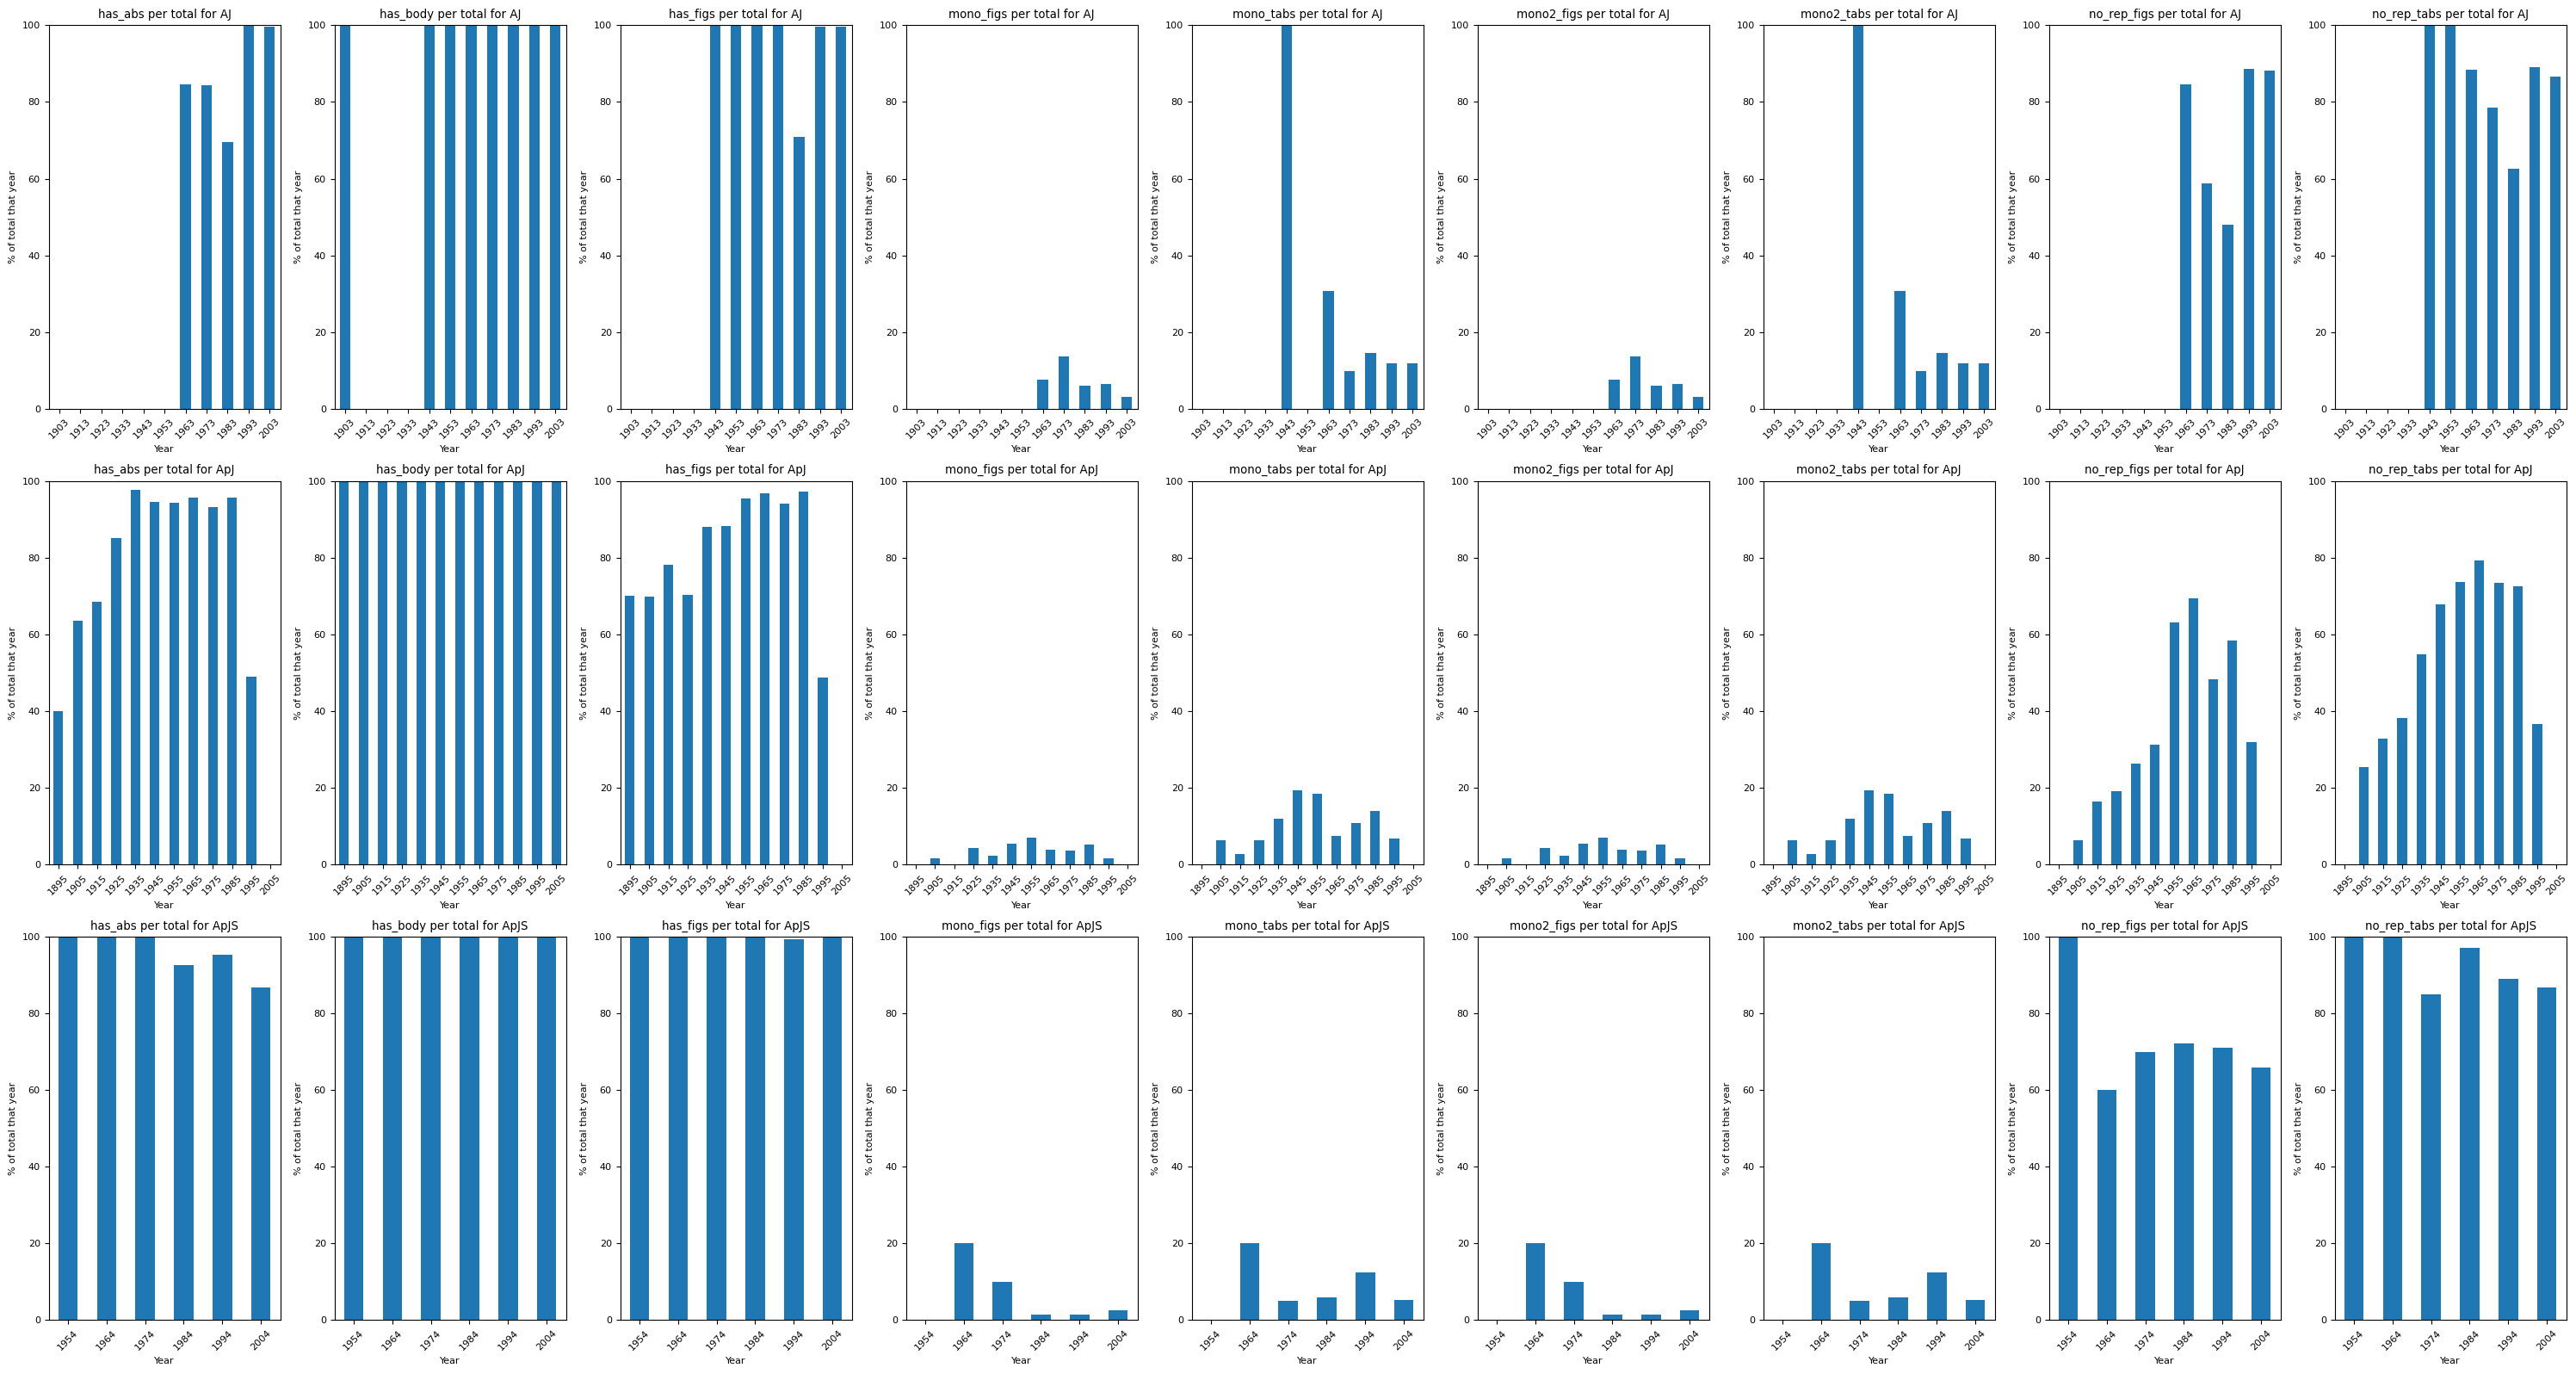

In [233]:
qnames = ['has_abs','has_body','has_figs','mono_figs','mono_tabs',
          'mono2_figs','mono2_tabs', 'no_rep_figs', 'no_rep_tabs']
sampleHist = '10Y'

# #fig, ax = plt.subplots(1,len(qnames), figsize=(30,8))
# fig, ax = plt.subplots(2,5, figsize=(30,16))
# ax = ax.flatten()

# for il,qname in enumerate(qnames):
#     counts = pd.Series(index=dfgrobid['Year'],data=np.array(dfgrobid[qname])).resample(sampleHist).sum()
#     tot = dfgrobid['Year'].value_counts().resample(sampleHist).sum() 
#     with np.errstate(invalid='ignore'): # take care of zeros later
#         quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
#     quant.plot(kind='bar',ax=ax[il])
#     ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
#     ax[il].set_title(qname+' per total')
#     ax[il].set_ylabel('% of total that year')
#     ax[il].set_xlabel('Year')
    
# plt.tight_layout()
# plt.show()

font = {'weight':'normal','size'   : 8}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(len(np.unique(dfgrobid['article'])),len(qnames), figsize=(30,8*2))
#fig.autofmt_xdate()

# index = dfgrobid['Year']
# data = np.array(dfgrobid[qname])
# counts = pd.Series(index=index,data=data).resample(sampleHist,label='left').sum()
# tot = dfgrobid['Year'].value_counts().resample(sampleHist).sum() 
# with np.errstate(invalid='ignore'): # take care of zeros later
#     quant_save = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
# ticks=quant_save.index.values

for il,qname in enumerate(qnames):
    for iar,ar in enumerate(np.unique(dfgrobid['article']).tolist()):
        index = dfgrobid.loc[dfgrobid['article']==ar]['Year']
        data = np.array(dfgrobid.loc[dfgrobid['article']==ar][qname])
        counts = pd.Series(index=index,data=data).resample(sampleHist,label='left').sum()
        tot = dfgrobid.loc[dfgrobid['article']==ar]['Year'].value_counts().resample(sampleHist).sum() 
        with np.errstate(invalid='ignore'): # take care of zeros later
            quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
        quant.plot(kind='bar',ax=ax[iar][il])#,xticks=ticks)
        #ax[iar][il].set_xlim(datetime.datetime(1884,1,1,0,0,0),datetime.datetime(2006,1,1,0,0,0))
        #ax.set_xlim([datetime.date(2014, 1, 26), datetime.date(2014, 2, 1)])    
        ax[iar][il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
        ax[iar][il].set_title(qname+' per total for ' + ar)
        ax[iar][il].set_ylabel('% of total that year')
        ax[iar][il].set_xlabel('Year')
        ax[iar][il].set_ylim(0,100)
plt.tight_layout()
plt.show()

Put it all together:

In [234]:
# step = int(sampleHist.split('Y')[0])
# years = np.arange(dfallt['Year'].min(), dfallt['Year'].max(), step).tolist(); refcount = np.zeros(len(years))
# rcount_fig = np.zeros(len(years)); rcount_cap = rcount_fig.copy(); 
# rcount_tab = rcount_fig.copy(); rcount_math=rcount_fig.copy()
# rcount_no = rcount_fig.copy()
# if 1997 not in years: years.append(1997)
# years = np.array(years)
# yearsOut = []
# for iy,y in enumerate(years[:-1]):
#     inds = np.where((df['years_old'].values<=years[iy+1])&(df['years_old'].values>years[iy]))[0]
#     if len(inds)> 0:
#         rcount_fig[iy] = np.sum(df['total:figure'].values[inds])
#         rcount_cap[iy] = np.sum(df['total:figure caption'].values[inds])
#         rcount_tab[iy] = np.sum(df['total:table'].values[inds])
#         rcount_math[iy] = np.sum(df['total:math formula'].values[inds])
#         rcount_no[iy] = np.sum(df['total:no label'].values[inds])
#     yearsOut.append(datetime.strptime(str(int(y)), "%Y"))
# #df2 = pd.DataFrame({'years':yearsOut, 'figure':rcount_fig, 'figure caption':rcount_cap, 'table':rcount_tab,
# #                    'math formula':rcount_math, 'no label':rcount_no})
# df2 = pd.DataFrame({'years':yearsOut, 'figure':rcount_fig, 'figure caption':rcount_cap, 'table':rcount_tab,
#                     'math formula':rcount_math})
# df2 =df2.set_index('years')

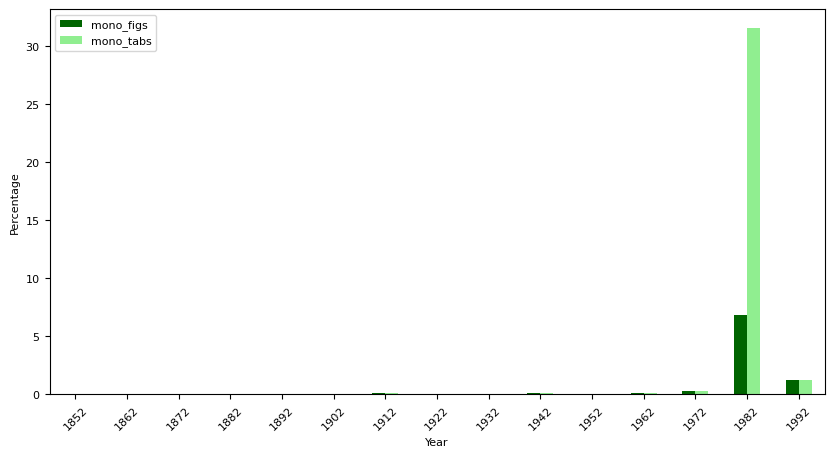

In [235]:
fig, ax = plt.subplots(figsize=(10,5))
dfgrobid2.plot(kind='bar',y=['mono_figs','mono_tabs'],stacked=False, ax=ax, color=['darkgreen','lightgreen','gray'])
ax.set_xticklabels([x.strftime("%Y") for x in dfgrobid2.index], rotation=45)

ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
plt.show()

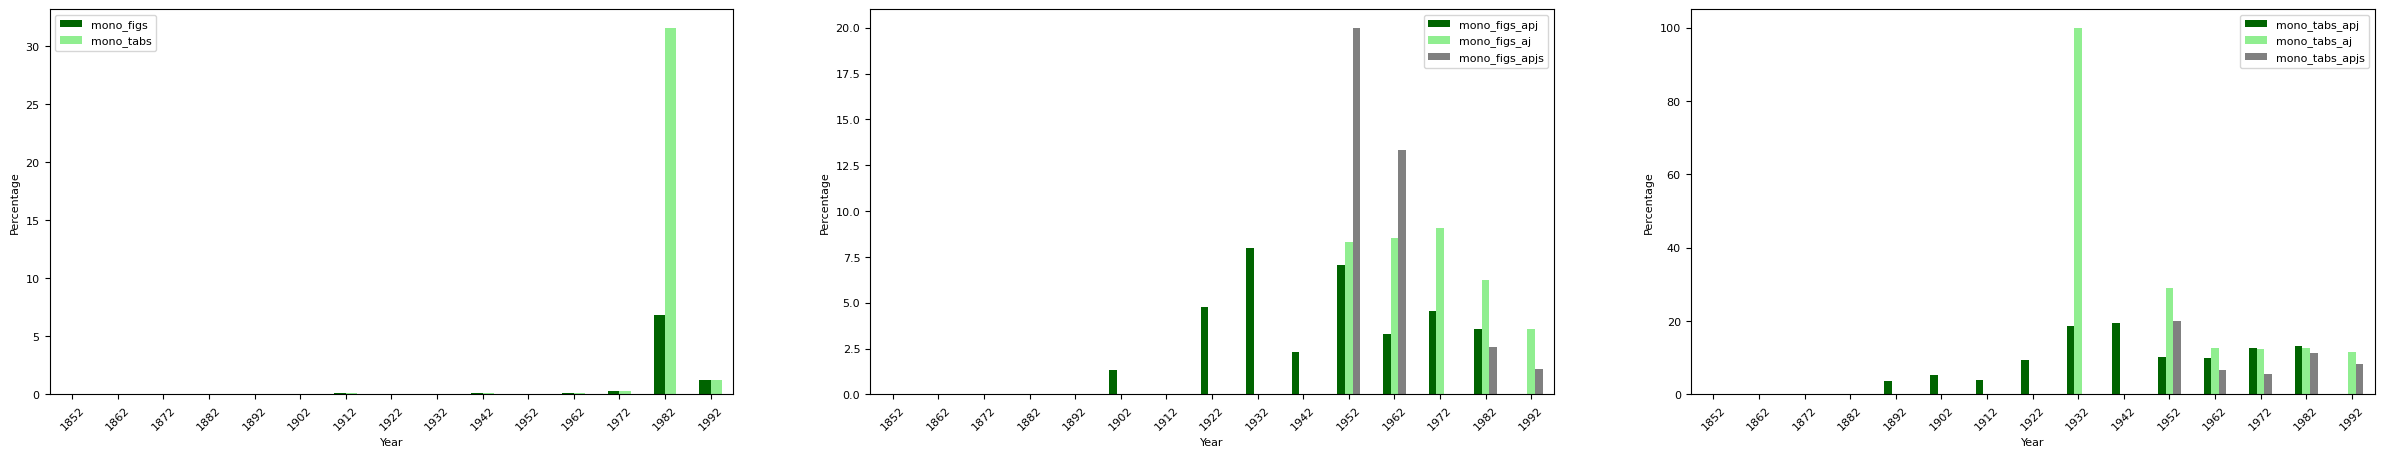

In [236]:
fig, ax = plt.subplots(1,3,figsize=(30,5))
dfgrobid2.plot(kind='bar',y=['mono_figs','mono_tabs'],stacked=False, ax=ax[0], color=['darkgreen','lightgreen','gray'])
ax[0].set_xticklabels([x.strftime("%Y") for x in dfgrobid2.index], rotation=45)

dfgrobid2.plot(kind='bar',y=['mono_figs_apj','mono_figs_aj','mono_figs_apjs'],stacked=False, ax=ax[1], color=['darkgreen','lightgreen','gray'])
ax[1].set_xticklabels([x.strftime("%Y") for x in dfgrobid2.index], rotation=45)

dfgrobid2.plot(kind='bar',y=['mono_tabs_apj','mono_tabs_aj','mono_tabs_apjs'],stacked=False, ax=ax[2], color=['darkgreen','lightgreen','gray'])
ax[2].set_xticklabels([x.strftime("%Y") for x in dfgrobid2.index], rotation=45)

for a in ax:
    a.set_ylabel('Percentage')
    a.set_xlabel('Year')
plt.show()

All together now (*all together now*) for PDF stuff:

In [238]:
# dfpdf = pd.DataFrame({'years':dfgrobid2.index.values, 
#                       'GROBID Figures':dfgrobid2['mono_figs'].values, 
#                       'GROBID Tables':dfgrobid2['mono_tabs'].values,
#                       'pdffigures2 Figures':df_pdf22['mono_figs'].values,
#                       'pdfigures2 Tables':df_pdf22['mono_tabs'].values,
#                      'GROBID ApJ Figures':dfgrobid2['mono_figs_apj'], 'GROBID AJ Figures':dfgrobid2['mono_figs_aj'],'GROBID ApJS Figures':dfgrobid2['mono_figs_apjs'],
#                      'GROBID ApJ Tables':dfgrobid2['mono_tabs_apj'], 'GROBID AJ Tables':dfgrobid2['mono_tabs_aj'],'GROBID ApJS Tables':dfgrobid2['mono_tabs_apjs']})
# # reorder for ref comment
dfpdf = pd.DataFrame({'years':dfgrobid2.index.values, 
                      'GROBID Figures':dfgrobid2['mono_figs'].values, 
                      'pdffigures2 Figures':df_pdf22['mono_figs'].values,
                      'GROBID Tables':dfgrobid2['mono_tabs'].values,
                      'pdfigures2 Tables':df_pdf22['mono_tabs'].values,
                     'GROBID ApJ Figures':dfgrobid2['mono_figs_apj'], 'GROBID AJ Figures':dfgrobid2['mono_figs_aj'],'GROBID ApJS Figures':dfgrobid2['mono_figs_apjs'],
                     'GROBID ApJ Tables':dfgrobid2['mono_tabs_apj'], 'GROBID AJ Tables':dfgrobid2['mono_tabs_aj'],'GROBID ApJS Tables':dfgrobid2['mono_tabs_apjs']})

dfpdf = dfpdf.set_index('years')

## Final plot(s?)

In [239]:
#font = {'weight':'normal','size'   : 20}
font = {'weight':'normal','size'   : 22} # tpdl

matplotlib.rc('font', **font)

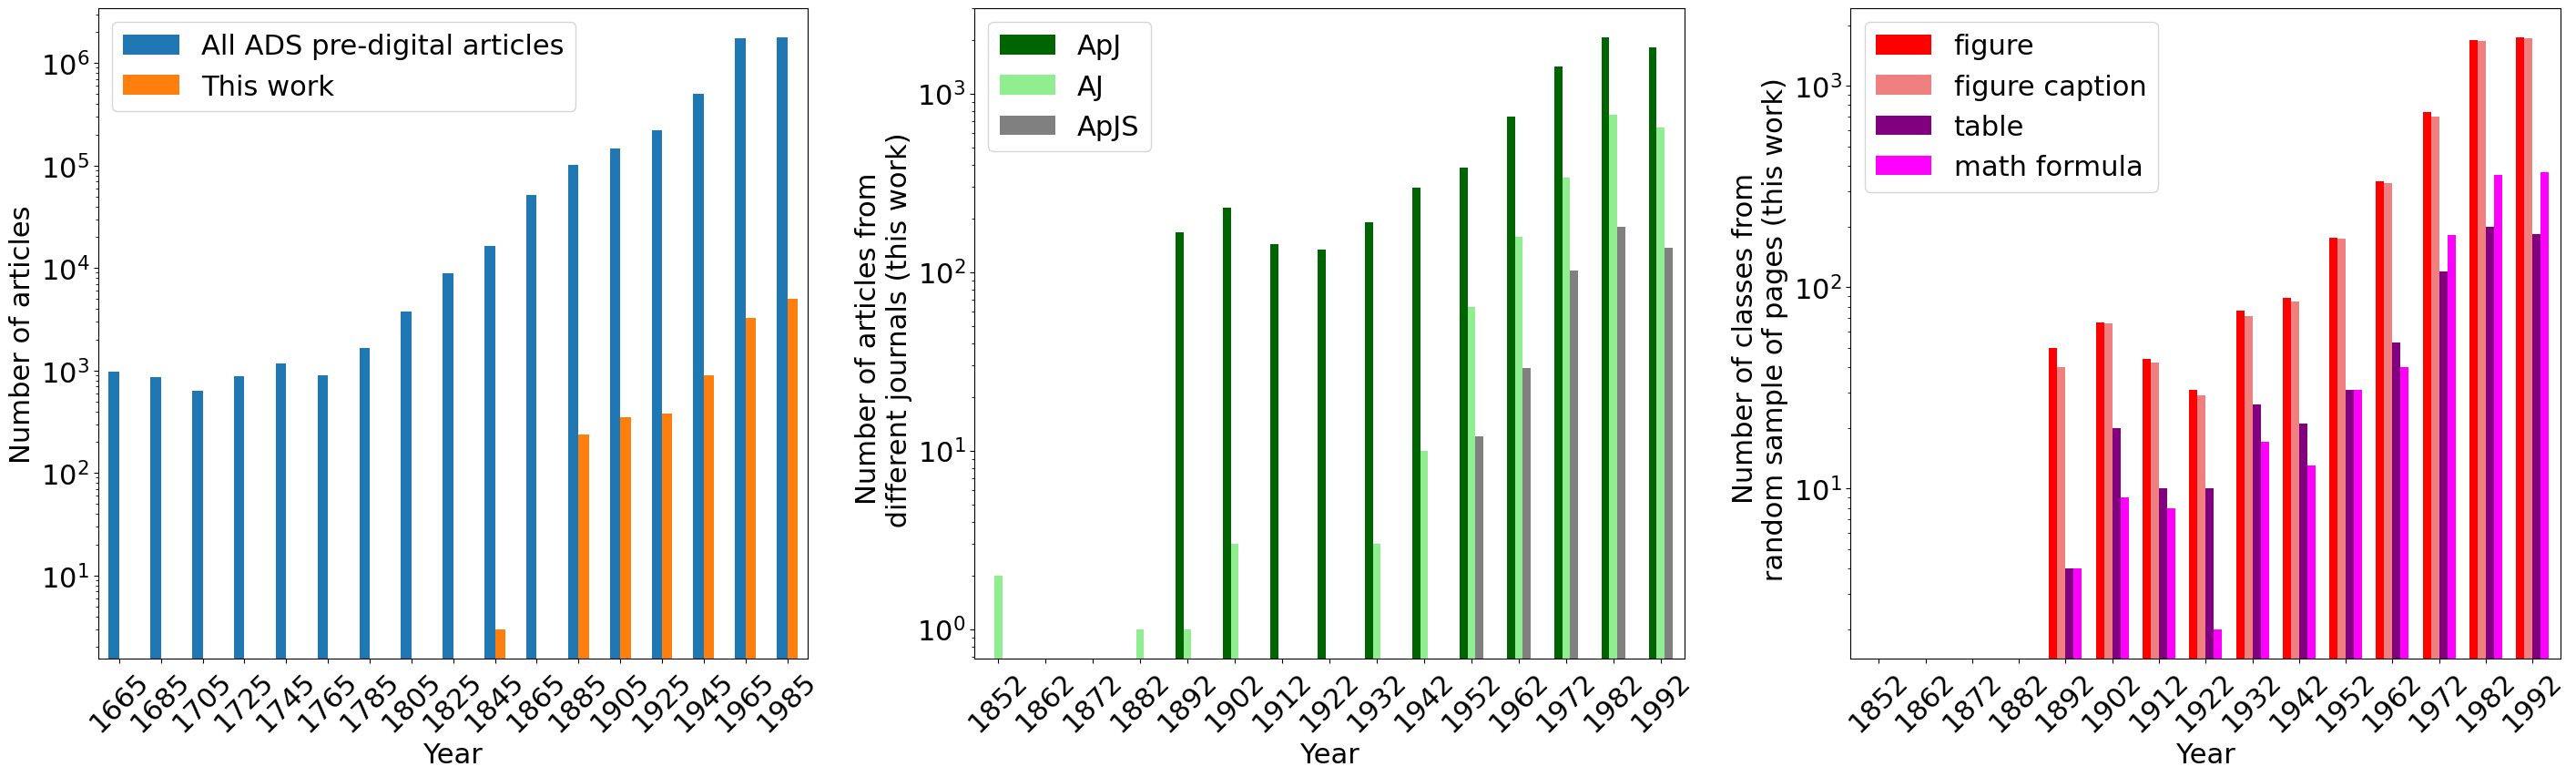

In [240]:
#fig, ax = plt.subplots(3,1, figsize=(9*1.5,9*3))
fig, ax = plt.subplots(1,3, figsize=(9*3.2,9*1)) # tpdl

dfall3.plot(kind='bar',stacked=False, ax=ax[0])
ax[0].set_xticklabels([x.strftime("%Y") for x in dfall3.index], rotation=45)
ax[0].set_ylabel('Number of articles')
ax[0].set_xlabel('Year')
ax[0].set_yscale('log')

# this work
dfallt3.plot(kind='bar',stacked=False, ax=ax[1], color=['darkgreen','lightgreen','gray'])
ax[1].set_xticklabels([x.strftime("%Y") for x in dfallt3.index], rotation=45)
ax[1].set_ylabel('Number of articles from \n different journals (this work)')
ax[1].set_xlabel('Year')
ax[1].set_yscale('log')


# ---- pages plot -----
# cols = quant.columns.tolist()
# colsind = cols.index('no label') # switch to last
# cols2 = []
# for ic,c in enumerate(cols):
#     if c != 'no label':
#         cols2.append(ic)
# cols2.append(colsind)
# quant = quant.reindex(columns=np.array(cols)[cols2])
        

#colors = ['red','lightcoral','purple','plum','magenta']
colors = ['red','lightcoral','purple','magenta']
df2.plot(kind='bar',stacked=False, ax=ax[2],color=colors,width=0.7)

ax[2].set_xticklabels([x.strftime("%Y") for x in df2.index], rotation=45)
#ax.set_title('Total )
ax[2].set_ylabel('Number of classes from \n random sample of pages (this work)')
ax[2].set_xlabel('Year')
ax[2].set_yscale('log')

fig.tight_layout()

#fig.savefig(fig_save_dir + 'year_class_distribution_log.png')
fig.savefig(fig_save_dir + 'year_class_distribution_log.pdf')

plt.show()

Also for the PDF mining results:

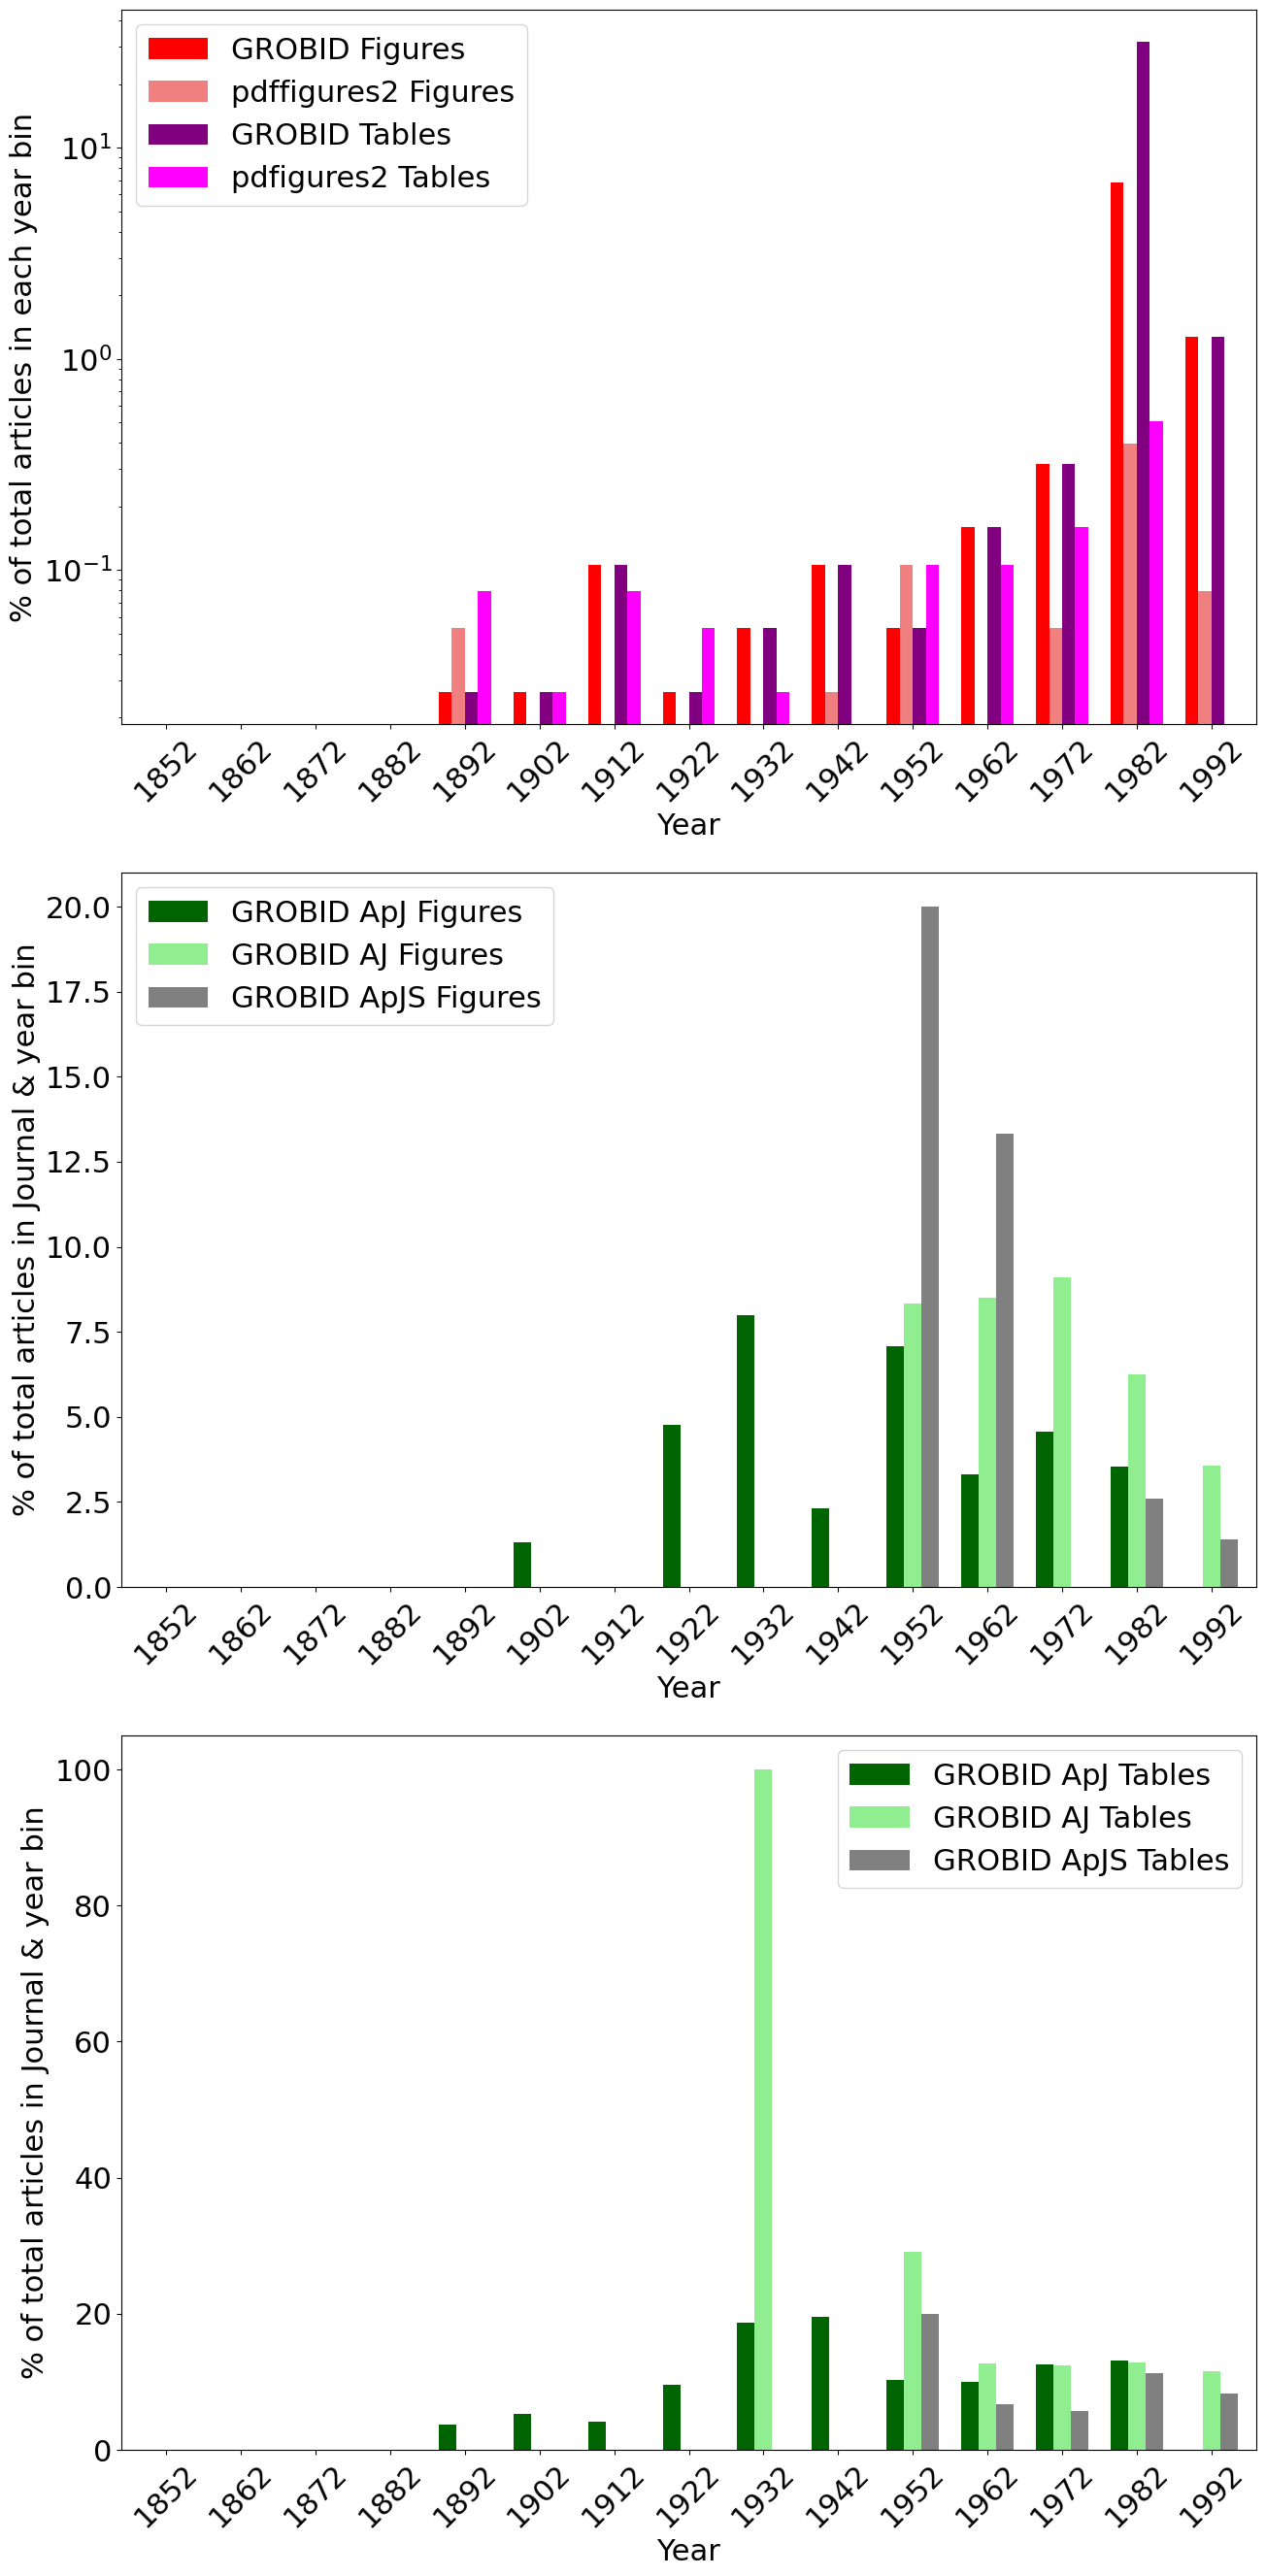

In [242]:
fig, ax = plt.subplots(3,1, figsize=(9*1.5,9*3)) # IJDT
#fig, ax = plt.subplots(1,3, figsize=(9*3.2,9*1)) # tpdl


#colors = ['red','lightcoral','purple','plum','magenta']
colors = ['red','lightcoral','purple','magenta']
# reorder for ref comment
#yorder = ['GROBID Figures','GROBID Tables','pdffigures2 Figures','pdfigures2 Tables']
yorder = ['GROBID Figures','pdffigures2 Figures', 'GROBID Tables','pdfigures2 Tables']
dfpdf.plot(kind='bar',y=yorder,
           stacked=False, ax=ax[0],color=colors,width=0.7)

ax[0].set_xticklabels([x.strftime("%Y") for x in dfpdf.index], rotation=45)
ax[0].set_ylabel('% of total articles in each year bin')
ax[0].set_xlabel('Year')
ax[0].set_yscale('log')

colors=['darkgreen','lightgreen','gray']
dfpdf.plot(kind='bar',y=['GROBID ApJ Figures','GROBID AJ Figures','GROBID ApJS Figures'],
           stacked=False, ax=ax[1],color=colors,width=0.7)
ax[1].set_xticklabels([x.strftime("%Y") for x in dfpdf.index], rotation=45)
ax[1].set_ylabel('% of total articles in Journal & year bin')
ax[1].set_xlabel('Year')

colors=['darkgreen','lightgreen','gray']
dfpdf.plot(kind='bar',y=['GROBID ApJ Tables','GROBID AJ Tables','GROBID ApJS Tables'],
           stacked=False, ax=ax[2],color=colors,width=0.7)
ax[2].set_xticklabels([x.strftime("%Y") for x in dfpdf.index], rotation=45)
ax[2].set_ylabel('% of total articles in Journal & year bin')
ax[2].set_xlabel('Year')

fig.tight_layout()

#fig.savefig(fig_save_dir + 'year_pdf_parsible_distribution_new.png')
fig.savefig(fig_save_dir + 'year_pdf_parsible_distribution_newparser.pdf')

plt.show()

In [109]:
fig_save_dir

'/Users/jnaiman/Dropbox/wwt_image_extraction/FigureLocalization/paper2/figures/'

In [110]:
dfpdf.head()

,GROBID Figures,pdffigures2 Figures,GROBID Tables,pdfigures2 Tables,GROBID ApJ Figures,GROBID AJ Figures,GROBID ApJS Figures,GROBID ApJ Tables,GROBID AJ Tables,GROBID ApJS Tables
years,,,,,,,,,,
1852-01-01,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1862-01-01,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1872-01-01,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1882-01-01,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1892-01-01,0.0,0.026532,0.053064,0.079597,0.0,0.0,0.0,3.703704,0.0,0.0


In [111]:
dfpdf.index.values

array(['1852-01-01T00:00:00.000000000', '1862-01-01T00:00:00.000000000',
       '1872-01-01T00:00:00.000000000', '1882-01-01T00:00:00.000000000',
       '1892-01-01T00:00:00.000000000', '1902-01-01T00:00:00.000000000',
       '1912-01-01T00:00:00.000000000', '1922-01-01T00:00:00.000000000',
       '1932-01-01T00:00:00.000000000', '1942-01-01T00:00:00.000000000',
       '1952-01-01T00:00:00.000000000', '1962-01-01T00:00:00.000000000',
       '1972-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [112]:
dfgrobid.head()

,Year,has_abs,has_body,has_figs,mono_figs,mono_tabs,mono2_figs,mono2_tabs,no_rep_figs,no_rep_tabs,article
0,1991-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,ApJS
1,1903-01-01,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,ApJ
2,1993-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,AJ
3,1961-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,ApJ
4,1981-01-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,ApJ


In [113]:
dfgrobid['mono2_figs'].sum()/len(dfgrobid)*100

3.475723003449191

In [114]:
df2

,figure,figure caption,table,math formula
years,,,,
1852-01-01,0.0,0.0,0.0,0.0
1862-01-01,0.0,0.0,0.0,0.0
1872-01-01,0.0,0.0,0.0,0.0
1882-01-01,0.0,0.0,0.0,0.0
1892-01-01,50.0,40.0,4.0,4.0
1902-01-01,67.0,66.0,20.0,9.0
1912-01-01,44.0,42.0,10.0,8.0
1922-01-01,31.0,29.0,10.0,2.0
1932-01-01,76.0,72.0,26.0,17.0


In [115]:
# print total
for l in LABELS:
    print(labels.count(l), l+'s')

5013 figures
4937 figure captions
1041 math formulas
553 no labels
677 tables


Let's compare the whole of ADS and what we have here:

In [116]:
#years_this

In [117]:
dfallt['Years_this'].sum()

10003

In [118]:
print("This work all ApJ, ADS listings ApJ, %")
print(dfallt['Ref_ApJ'].sum(),dfall['All ApJ'].sum(), dfallt['Ref_ApJ'].sum()/dfall['All ApJ'].sum())
print("This work all AJ, ADS listings AJ, %")
print(dfallt['Ref_AJ'].sum(),dfall['All AJ'].sum(), dfallt['Ref_AJ'].sum()/dfall['All AJ'].sum())
print("This work all ApJS, ADS listings ApJS, %")
print(dfallt['Ref_ApJS'].sum(),dfall['All ApJS'].sum(), dfallt['Ref_ApJS'].sum()/dfall['All ApJS'].sum())
print("This work all, ADS listings ALL, %")
allArt = dfall['All AJ'].sum() + dfall['All ApJ'].sum() + dfall['All ApJS'].sum()
thisArt = dfallt['Ref_AJ'].sum() + dfallt['Ref_ApJ'].sum() + dfallt['Ref_ApJS'].sum()
print(thisArt, allArt, thisArt/allArt)

This work all ApJ, ADS listings ApJ, %
7564.0 39850.0 0.18981179422835634
This work all AJ, ADS listings AJ, %
1981.0 15995.0 0.12385120350109409
This work all ApJS, ADS listings ApJS, %
458.0 2501.0 0.1831267493002799
This work all, ADS listings ALL, %
10003.0 58346.0 0.1714427724265588


In [119]:
dfall.head()

,All ADS pre-digital articles,All ApJ,All AJ,All ApJS
years,,,,
1665-01-01 00:00:00,980.0,0.0,0.0,0.0
1685-01-01 00:00:00,870.0,0.0,0.0,0.0
1705-01-01 00:00:00,635.0,0.0,0.0,0.0
1725-01-01 00:00:00,880.0,0.0,0.0,0.0
1745-01-01 00:00:00,1166.0,0.0,0.0,0.0


Make a plot for just the PDF-parsable steps: